- VAE test for code reviewed

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
import sys
import os
import logging
import galsim
import random
import cmath as cm
import math
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Add, Multiply, Reshape, Flatten, BatchNormalization
from tensorflow.keras.models import Model, Sequential
import scipy
import scipy.stats as stats
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline
from tensorflow.keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, Flatten,  Reshape, UpSampling2D, Cropping2D, Conv2DTranspose, PReLU, Concatenate, Lambda, BatchNormalization, concatenate
import tensorflow as tf
import seaborn as sns

In [150]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
from tools_for_VAE import vae_functions, model, plot

from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_vae_conv, denorm, norm
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, createCircularMask, mean_var, plot_corner_latent

In [151]:
from importlib import reload

reload(plot)

from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, createCircularMask, mean_var, plot_corner_latent

In [3]:
from generator_vae import BatchGenerator

# Loading the trained VAE

In [5]:
vae_lsst_r_band_conv, encoder_R, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/R_band/VAE/noisy/v12/',1, folder = True)

In [6]:
vae_lsst_conv, encoder_LSST, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v10/',6, folder= True) # v7 OK

In [7]:
vae_lsst_euclid_conv, encoder_LSST_EUCLID, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST_EUCLID/VAE/noisy/v7/',10, folder = True)

# Generators

In [12]:
list_of_samples=['/sps/lsst/users/barcelin/data/single/changing_lsst_PSF/galaxies_COSMOS_test_v3.npy']#galaxies_COSMOS_test_2_v3.npy

In [23]:
bands_r = [6]

In [14]:
batch_gen = BatchGenerator(bands_r, list_of_samples, total_sample_size=10000, batch_size= 100, size_of_lists = 10000, training_or_validation = None, noisy = True)

In [24]:
bands_lsst = [4,5,6,7,8,9]

In [16]:
batch_gen_lsst = BatchGenerator(bands_lsst, list_of_samples,total_sample_size=10000, batch_size= 100, size_of_lists = 10000, training_or_validation = None, noisy = True)#list_of_redshift,

In [25]:
bands_lsst_euclid = [0,1,2,3,4,5,6,7,8,9]

In [18]:
batch_gen_lsst_euclid = BatchGenerator(bands_lsst_euclid, list_of_samples,total_sample_size=10000, batch_size= 100, size_of_lists = 10000, training_or_validation = None, noisy = True)#list_of_redshift,

In [19]:
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

# Test plot vae R band only

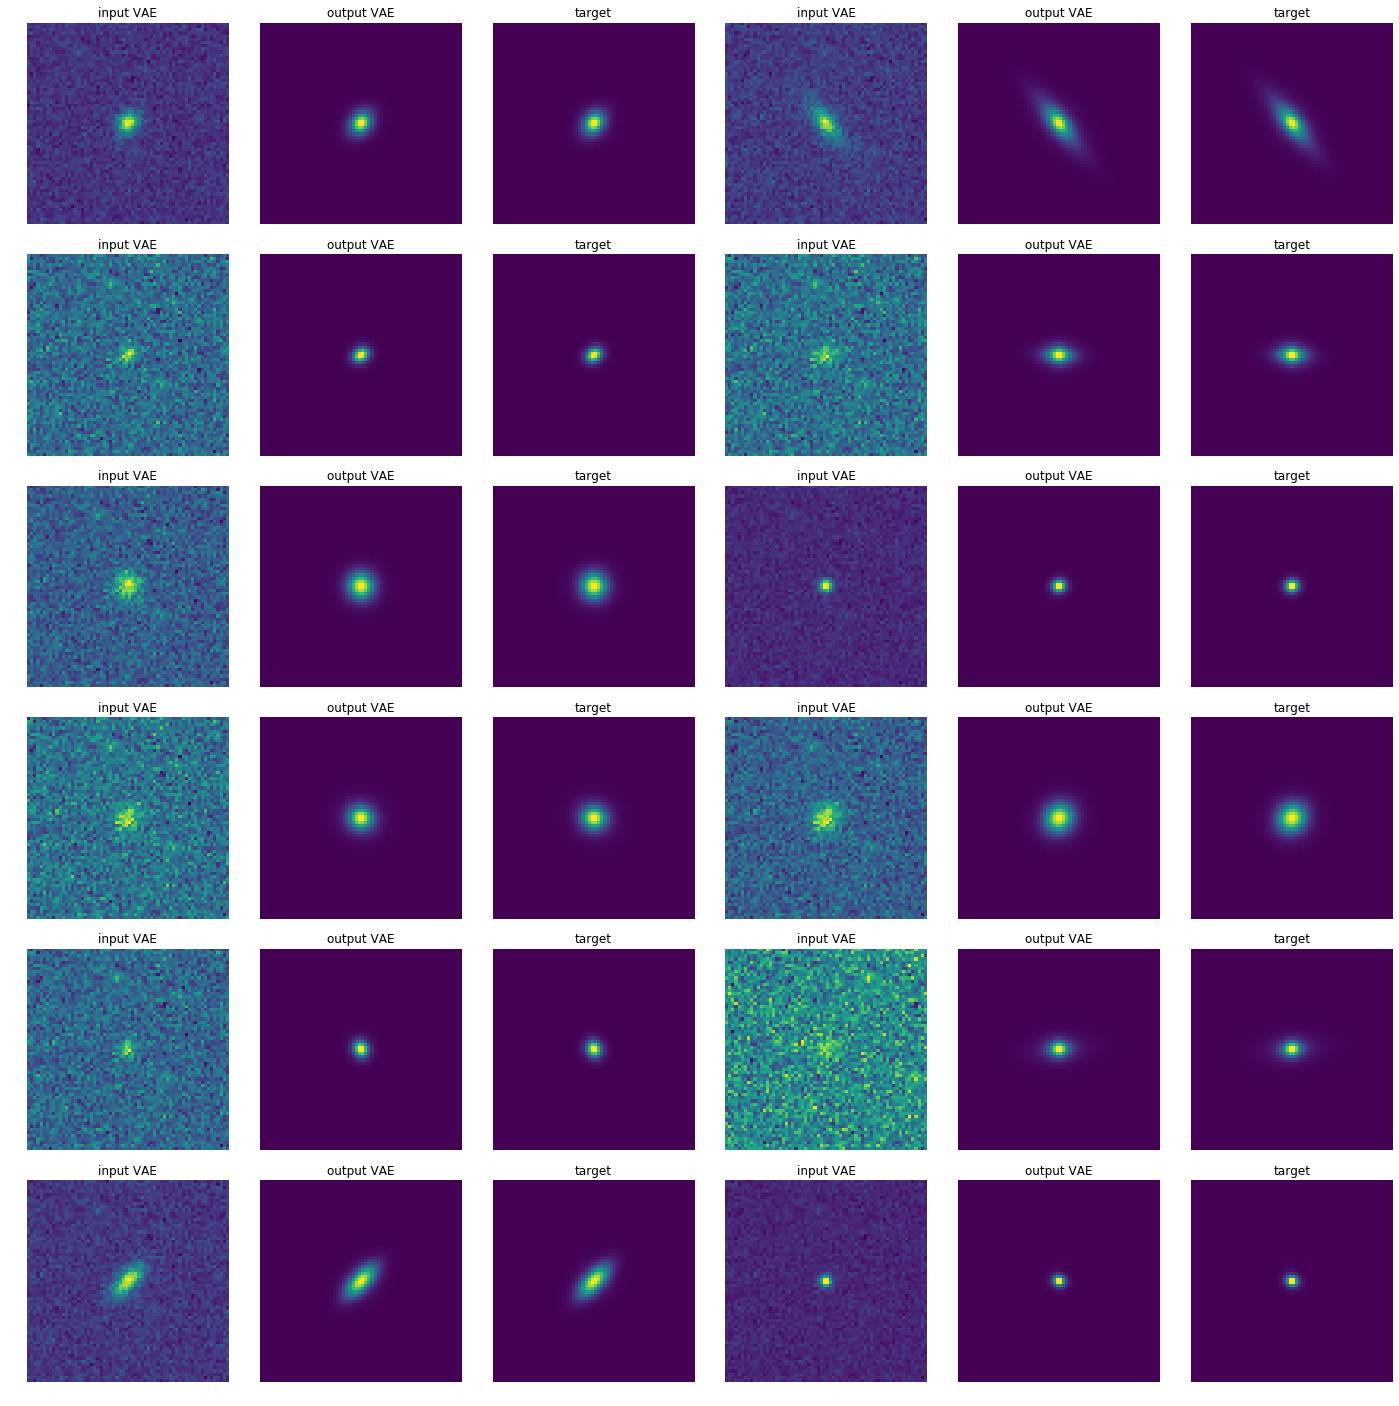

In [28]:
N_plot = 6
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_vae = batch_gen.__getitem__(2)
output_vae = vae_lsst_r_band_conv.predict(input_vae[0], batch_size = 100)

input_noisy = denorm(input_vae[0], bands_r, channel_last = True)
input_noiseless = denorm(input_vae[1], bands_r, channel_last = True)
output_vae = denorm(output_vae, bands_r, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        
        axes[i,j].imshow(input_noisy[indices[i*N_plot+j]].reshape((64,64)))
        axes[i,j+1].imshow(output_vae[indices[i*N_plot+j]].reshape((64,64)))
        axes[i,j+2].imshow(input_noiseless[indices[i*N_plot+j]].reshape((64,64)))

        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


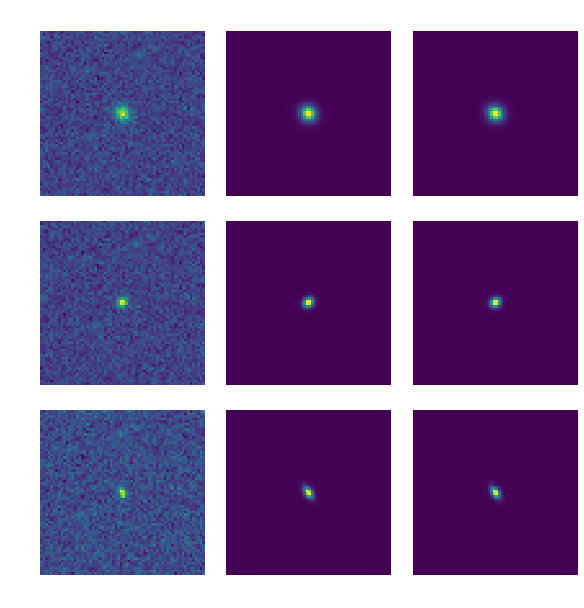

In [29]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)


N_plot = 3
fig, axes = plt.subplots(3, N_plot, figsize=(10, 10))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_vae = batch_gen.__getitem__(2)
output_vae = vae_lsst_r_band_conv.predict(input_vae[0], batch_size = 100)

input_noisy = denorm(input_vae[0], bands_r, channel_last = True)
input_noiseless = denorm(input_vae[1], bands_r, channel_last = True)
output_vae = denorm(output_vae, bands_r, channel_last = True)

for i in range(3):
    for j in range(0,N_plot,3):
        axes[i,j].imshow(input_noisy[indices[i*N_plot+j]].reshape((64,64)))
        axes[i,j+1].imshow(output_vae[indices[i*N_plot+j]].reshape((64,64)))
        axes[i,j+2].imshow(input_noiseless[indices[i*N_plot+j]].reshape((64,64)))
        
        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE', color = "w")
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE', color = "w")
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target', color = "w")

# Test plot for LSST all filters

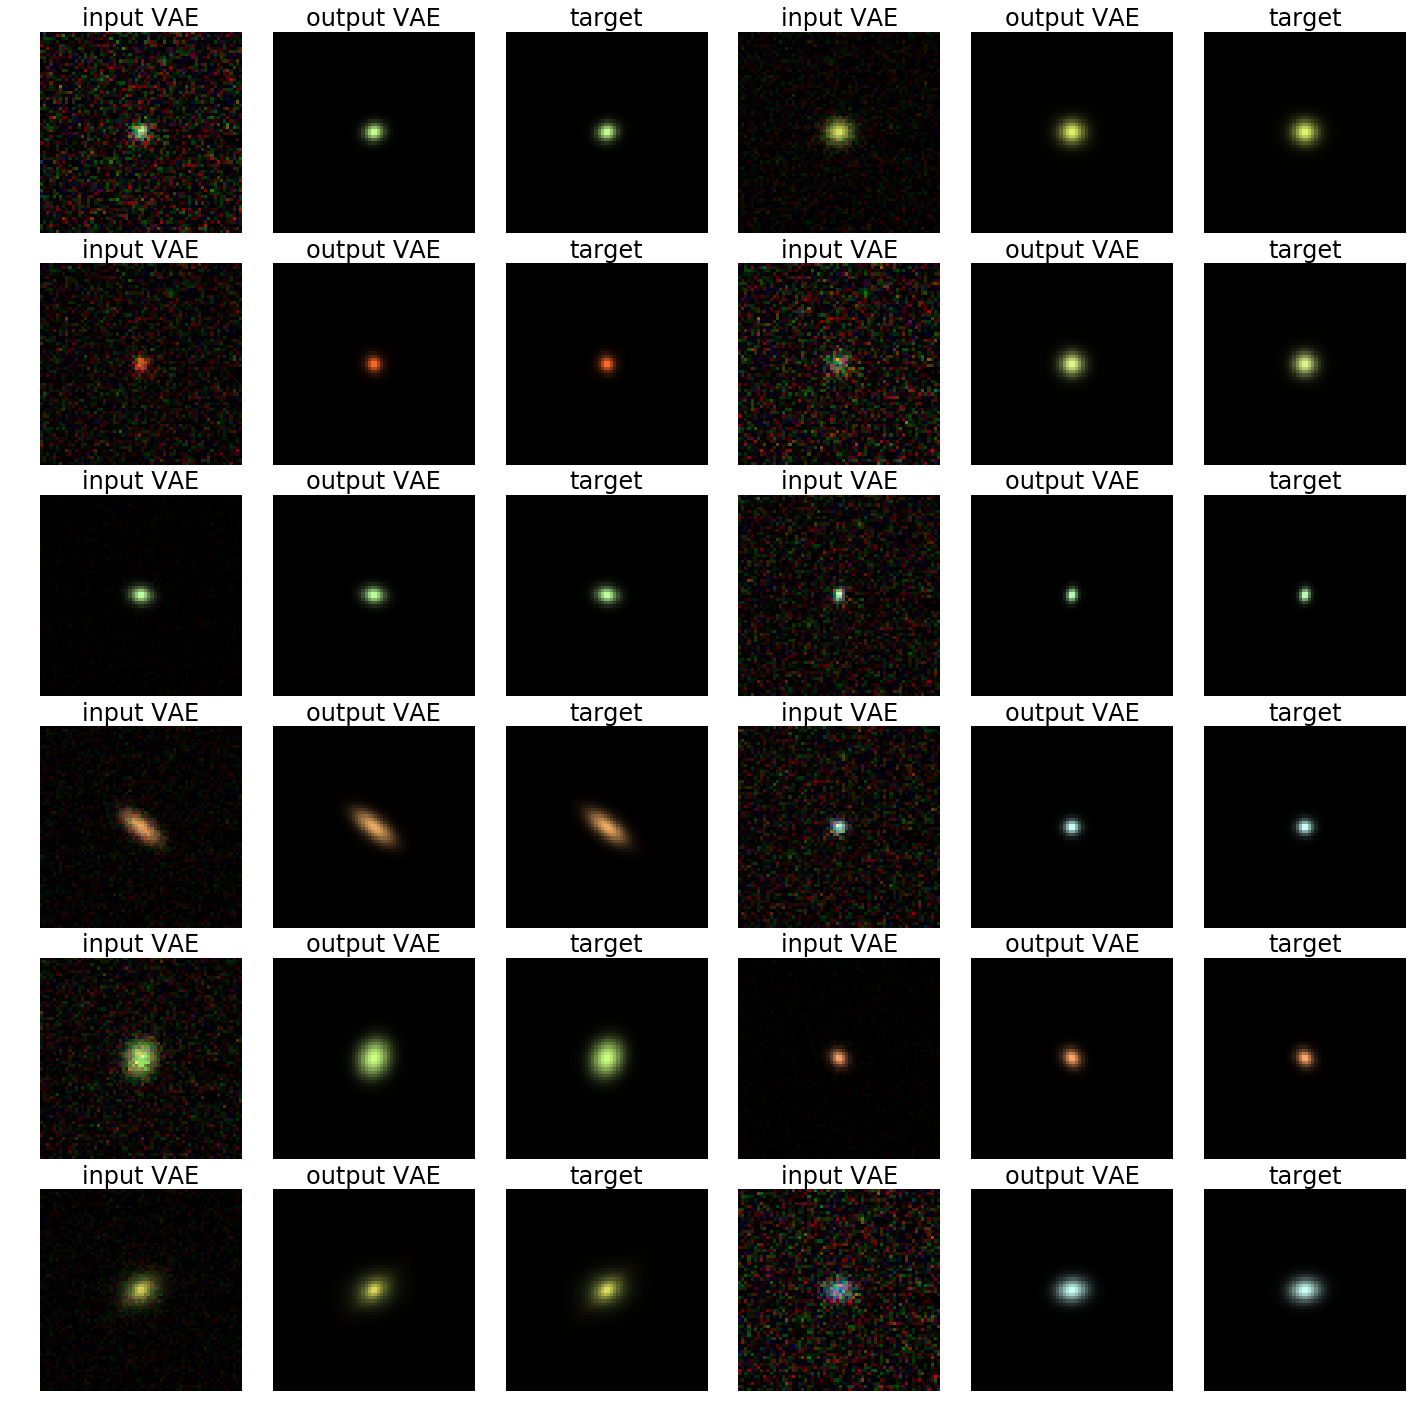

In [34]:
N_plot = 6
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_vae = batch_gen_lsst.__getitem__(2)
output_vae = vae_lsst_conv.predict(input_vae[0], batch_size = 100)

input_noisy = denorm(input_vae[0], bands_lsst, channel_last = True)
input_noiseless = denorm(input_vae[1], bands_lsst, channel_last = True)
output_vae = denorm(output_vae, bands_lsst, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        
        plot_rgb_lsst(input_noisy[indices[i*N_plot+j]], stamp_size, axes[i,j])
        plot_rgb_lsst(output_vae[indices[i*N_plot+j]], stamp_size, axes[i,j+1])
        plot_rgb_lsst(input_noiseless[indices[i*N_plot+j]], stamp_size, axes[i,j+2])

        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

1101.9999999999995
2256.9999999999995
1988.9999999999995


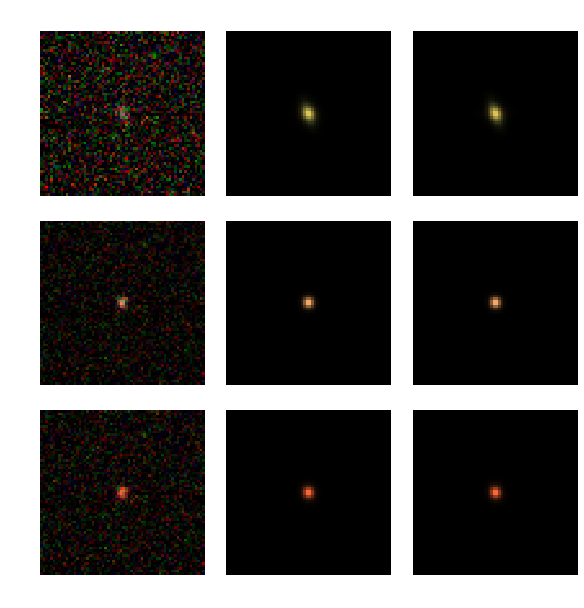

In [74]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

N_plot = 3
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_vae = batch_gen_lsst.__getitem__(2)
output_vae = vae_lsst_conv.predict(input_vae[0], batch_size = 100)

input_noisy = denorm(input_vae[0], bands_lsst, channel_last = True)
input_noiseless = denorm(input_vae[1], bands_lsst, channel_last = True)
output_vae = denorm(output_vae, bands_lsst, channel_last = True)

for i in range(3):
    for j in range(0,N_plot,3):
        
        plot_rgb_lsst(input_noisy[indices[i*N_plot+j]], stamp_size, axes[i,j])
        plot_rgb_lsst(output_vae[indices[i*N_plot+j]], stamp_size, axes[i,j+1])
        plot_rgb_lsst(input_noiseless[indices[i*N_plot+j]], stamp_size, axes[i,j+2])
        
        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE', color = "w")
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE', color = "w")
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target', color = "w")

# Test plot for LSST+Euclid filters

28605.000000000633
33566.117
28079.056640625033
1454.0
800.5648
809.6339111328122
2223.0000000000005
1707.6853
1764.8681640625002
3309.9999999999986
3147.5667
3151.3229980468764
8601.0
8091.6914
8367.081054687513
3885.0
3700.7637
3834.6828613281214
6936.999999999986
6588.907
6838.433593749996
1444.0000000000002
1030.8715
1039.8994140624998
25649.000000000153
8022.1445
25561.91992187502
1817.9999999999998
1556.1078
1609.6604003906245
11390.999999999955
10143.464
11349.446289062556
4259.999999999998
3786.4106
3932.708984374999


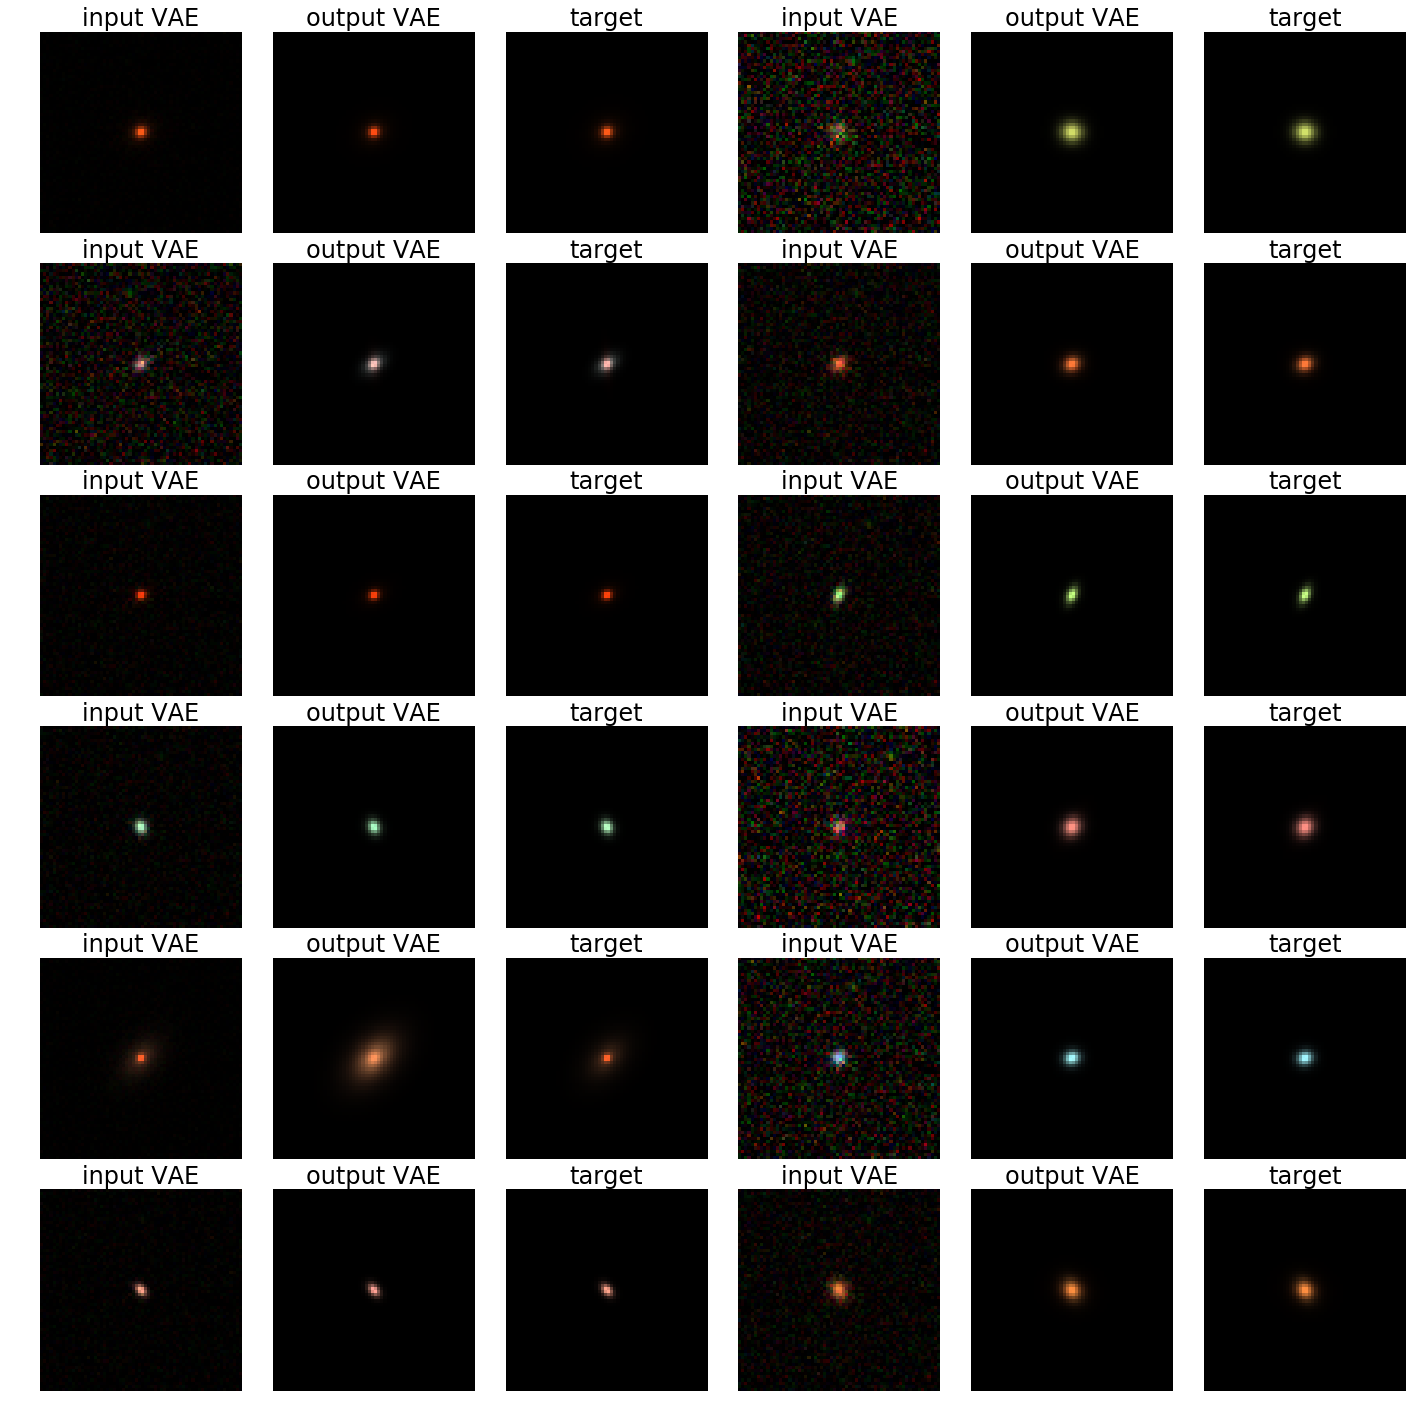

In [125]:
N_plot = 6
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_vae = batch_gen_lsst_euclid.__getitem__(2)
output_vae = vae_lsst_euclid_conv.predict(input_vae[0], batch_size = 100)


#input_noisy = input_vae[0]
#input_noiseless = input_vae[1]
input_noisy = denorm(input_vae[0], bands_lsst_euclid, channel_last = True)
input_noiseless = denorm(input_vae[1], bands_lsst_euclid, channel_last = True)
output_vae = denorm(output_vae, bands_lsst_euclid, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):

        plot_rgb_lsst_euclid(input_noisy[indices[i*N_plot+j]], stamp_size, axes[i,j])
        plot_rgb_lsst_euclid(output_vae[indices[i*N_plot+j]], stamp_size, axes[i,j+1])
        plot_rgb_lsst_euclid(input_noiseless[indices[i*N_plot+j]], stamp_size, axes[i,j+2])

        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

## VAE LSST R band

In [127]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

I= [6.48221069e+05, 4.36202878e+05, 2.27700000e+05, 4.66676013e+04,2.91513800e+02, 2.64974100e+03, 4.66828170e+03, 5.79938030e+03,5.72952590e+03, 3.50687710e+03]
beta = 5

ellipticities = []
redshift_R=[]
e=[]

N = 100

lum_in_simple = np.empty([N,N,],dtype='float32')
lum_out_simple= np.empty([N,N,], dtype='float32')

for j in range(N):
    input_vae = batch_gen.__getitem__(2)
    output_vae = vae_lsst_r_band_conv.predict(input_vae[0], batch_size = batch_size)
    
    input_noisy = denorm(input_vae[0], bands_r, channel_last = True)
    input_noiseless = denorm(input_vae[1], bands_r, channel_last = True)
    output_vae = denorm (output_vae, bands_r, channel_last = True)
    
    for i in range (len(input_vae[0])):
        try: 
            gal_image = galsim.Image(input_noiseless[i].reshape((64,64)))
            gal_image.scale = pix_scale

            # Measurements of shapes
            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_in = [res.corrected_e1, res.corrected_e2]
            e_beta_in = [res.observed_shape.e, res.observed_shape.beta.rad]

            gal_image = galsim.Image(output_vae[i].reshape((64,64)))
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_out = [res.corrected_e1, res.corrected_e2]
            e_beta_out = [res.observed_shape.e, res.observed_shape.beta.rad]

            ellipticities.append([e_in, e_out])
            e.append([e_beta_in, e_beta_out])

            # Measurement of fluxes
            mask = createCircularMask(64,64,None,5)
            masked_img_in_simple = input_noiseless[i].reshape((64,64)).copy()
            masked_img_in_simple[~mask] = 0  

            masked_img_out_simple = output_vae[i].reshape((64,64)).copy()
            masked_img_out_simple[~mask] = 0

            # Calculate the luminosity by substracting the noise
            lum_in_simple[j,i] = np.sum(masked_img_in_simple)
            lum_out_simple[j,i] = np.sum(masked_img_out_simple)
          
        except :
            print('erreur')
            pass
        continue

ellipticities_r_band = np.array(ellipticities)
e_beta = np.array(e)

In [128]:
ellipticities_r_band[:,0,1].shape

(10000,)

### Shape plots

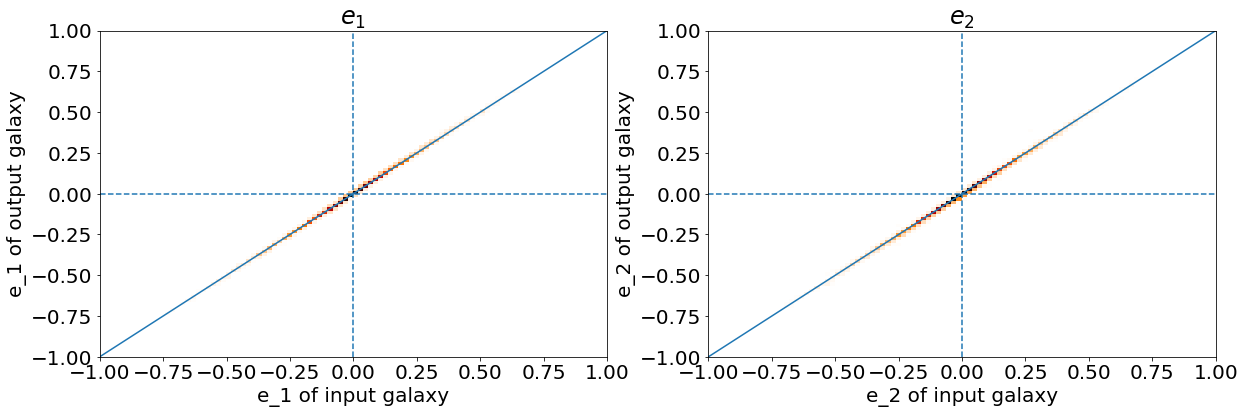

In [129]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(20,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=24)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'
    axes[i].set_xlabel('e_'+str(i+1)+' of input galaxy')
    axes[i].set_ylabel('e_'+str(i+1)+' of output galaxy')

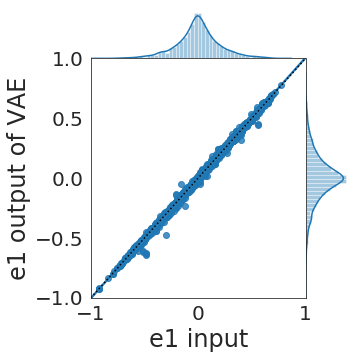

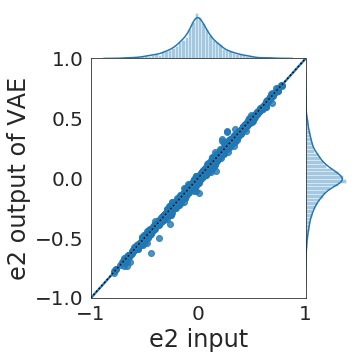

In [165]:
with sns.axes_style('white'):
            g = sns.jointplot(ellipticities_r_band[:,0,0], ellipticities_r_band[:,1,0], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

            g = sns.jointplot(ellipticities_r_band[:,0,1], ellipticities_r_band[:,1,1], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e2 input', 'e2 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

Text(0, 0.5, 'e of output galaxy')

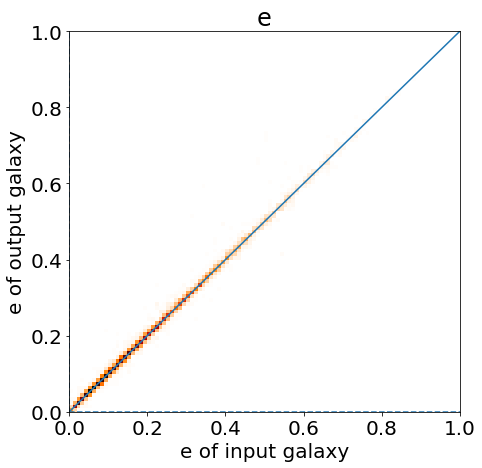

In [130]:
fig = plt.subplots(1,1, figsize=(7,7))
emax = 1
_ = plt.hist2d(e_beta[:,0,0], e_beta[:,1,0], bins=np.linspace(0,+emax,101), cmap=mpl.cm.gist_heat_r)
plt.plot([0,+emax],[0,+emax])
plt.axhline(y=0, ls='--')
plt.axvline(x=0, ls='--')
plt.title('e'.format(i+1),fontsize=24)# color="w", 
#plt.xaxis.label#.set_color('w')
plt.tick_params(axis='x')#, colors='w'
plt.tick_params(axis='y')#, colors='w'
plt.xlabel('e of input galaxy')
plt.ylabel('e of output galaxy')

Text(0, 0.5, 'beta of output galaxy')

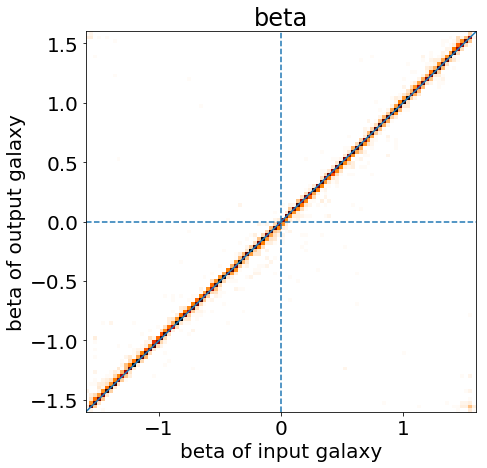

In [131]:
fig = plt.subplots(1,1, figsize=(7,7))
emax = 1.6
_ = plt.hist2d(e_beta[:,0,1], e_beta[:,1,1], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
plt.plot([-emax,+emax],[-emax,+emax])
plt.axhline(y=0, ls='--')
plt.axvline(x=0, ls='--')
plt.title('beta'.format(i+1),fontsize=24)# color="w", 
#plt.xaxis.label#.set_color('w')
plt.tick_params(axis='x')#, colors='w'
plt.tick_params(axis='y')#, colors='w'
plt.xlabel('beta of input galaxy')
plt.ylabel('beta of output galaxy')

### Luminosity plots

In [132]:
lum_in_simple = np.concatenate(lum_in_simple)
lum_out_simple = np.concatenate(lum_out_simple)

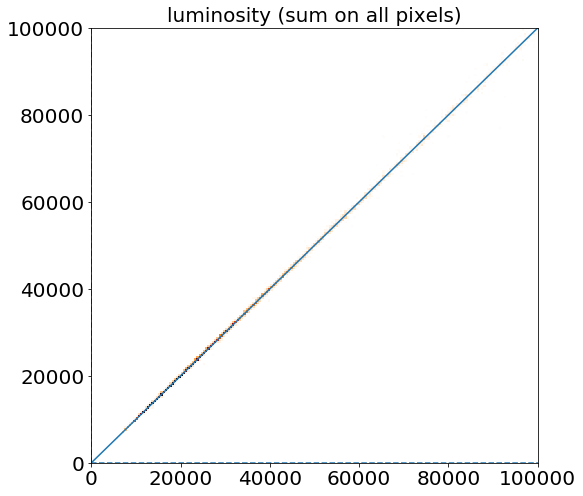

In [133]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = 100000
_ = axes.hist2d(lum_in_simple, lum_out_simple, bins=np.linspace(0,+emax,200), cmap=mpl.cm.gist_heat_r)
axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')

(0, 2000000)

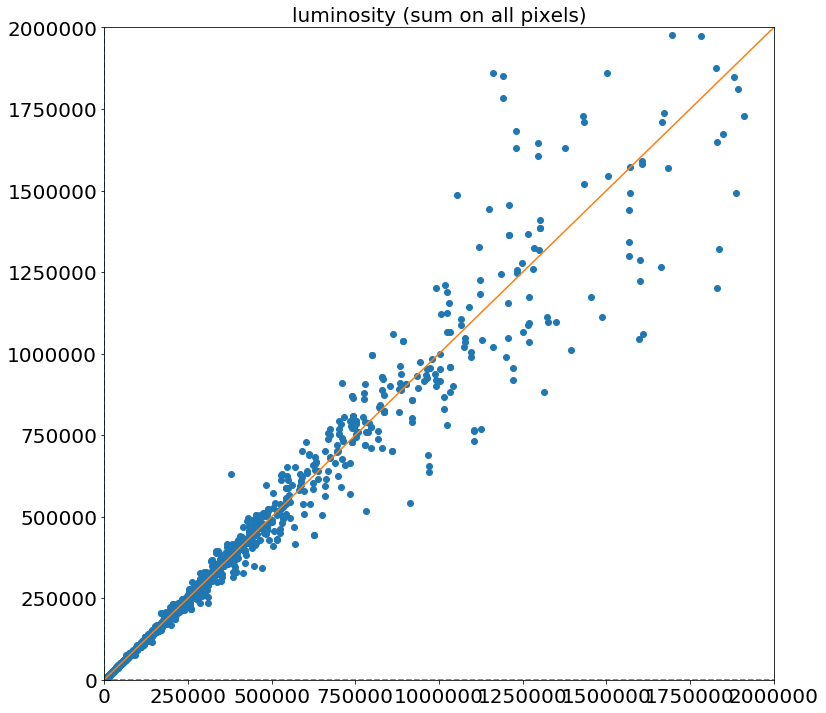

In [134]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(12,12))
emax = 2000000
axes.plot(lum_in_simple, lum_out_simple,'o')

axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlim(0,emax)
axes.set_ylim(0,emax)

(0, 200000)

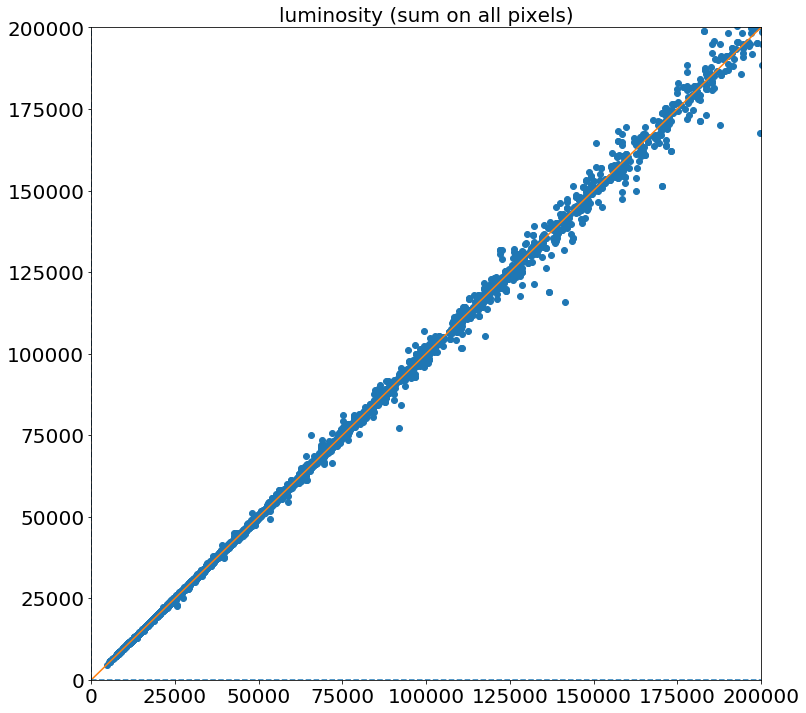

In [135]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(12,12))
emax = 200000
axes.plot(lum_in_simple, lum_out_simple,'o')

axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlim(0,emax)
axes.set_ylim(0,emax)

### Delta_e1 / Delta_e2

In [143]:
delta_e1 = ellipticities_r_band[:,0,0]-ellipticities_r_band[:,1,0]
delta_e2 = ellipticities_r_band[:,0,1]-ellipticities_r_band[:,1,1]

(-0.4, 0.4)

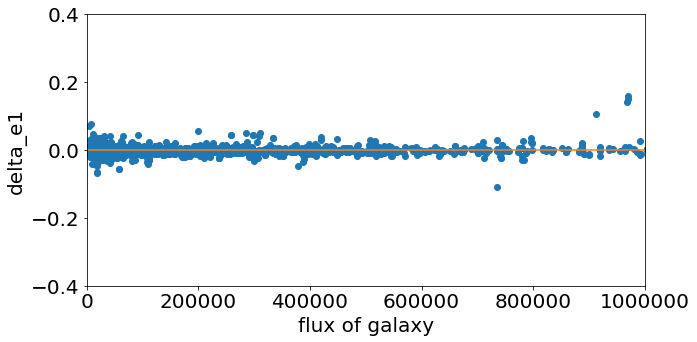

In [144]:
fig = plt.subplots(1,1, figsize=(10,5))
plt.plot(lum_in_simple[:len(delta_e1)], delta_e1, 'o')
plt.xlim(0,1000000)
plt.xlabel('flux of galaxy')
plt.ylabel('delta_e1')
plt.plot([0,1000000],[0,0])
plt.ylim(-0.4,0.4)

(-0.4, 0.4)

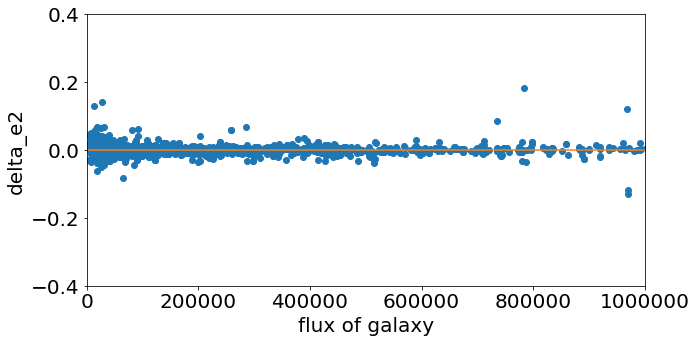

In [145]:
fig = plt.subplots(1,1, figsize=(10,5))
plt.plot(lum_in_simple[:len(delta_e2)], delta_e2, 'o')
plt.xlim(0,1000000)
plt.xlabel('flux of galaxy')
plt.ylabel('delta_e2')
plt.plot([0,1000000],[0,0])
plt.ylim(-0.4,0.4)

### Corner plot latent space

In [152]:
batch_size = 100

In [153]:
a = batch_gen.__getitem__(2)
output_enc = encoder_R.predict(a[0], batch_size = batch_size)

In [158]:
latent_dim =32
epsilon_std = 1.0

In [159]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = np.random.normal( 0.,
                              epsilon_std,(batch_size, latent_dim))
    return z_mean + np.exp(z_log_var / 2) * epsilon

In [160]:
z = []
for i in range (100):
    a = batch_gen.__getitem__(2)
    output_enc = encoder_R.predict(a[0], batch_size = batch_size)
    z.append(sampling(output_enc))


In [161]:
z = np.concatenate(z, axis = 0)

In [162]:
len(z)

10000

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


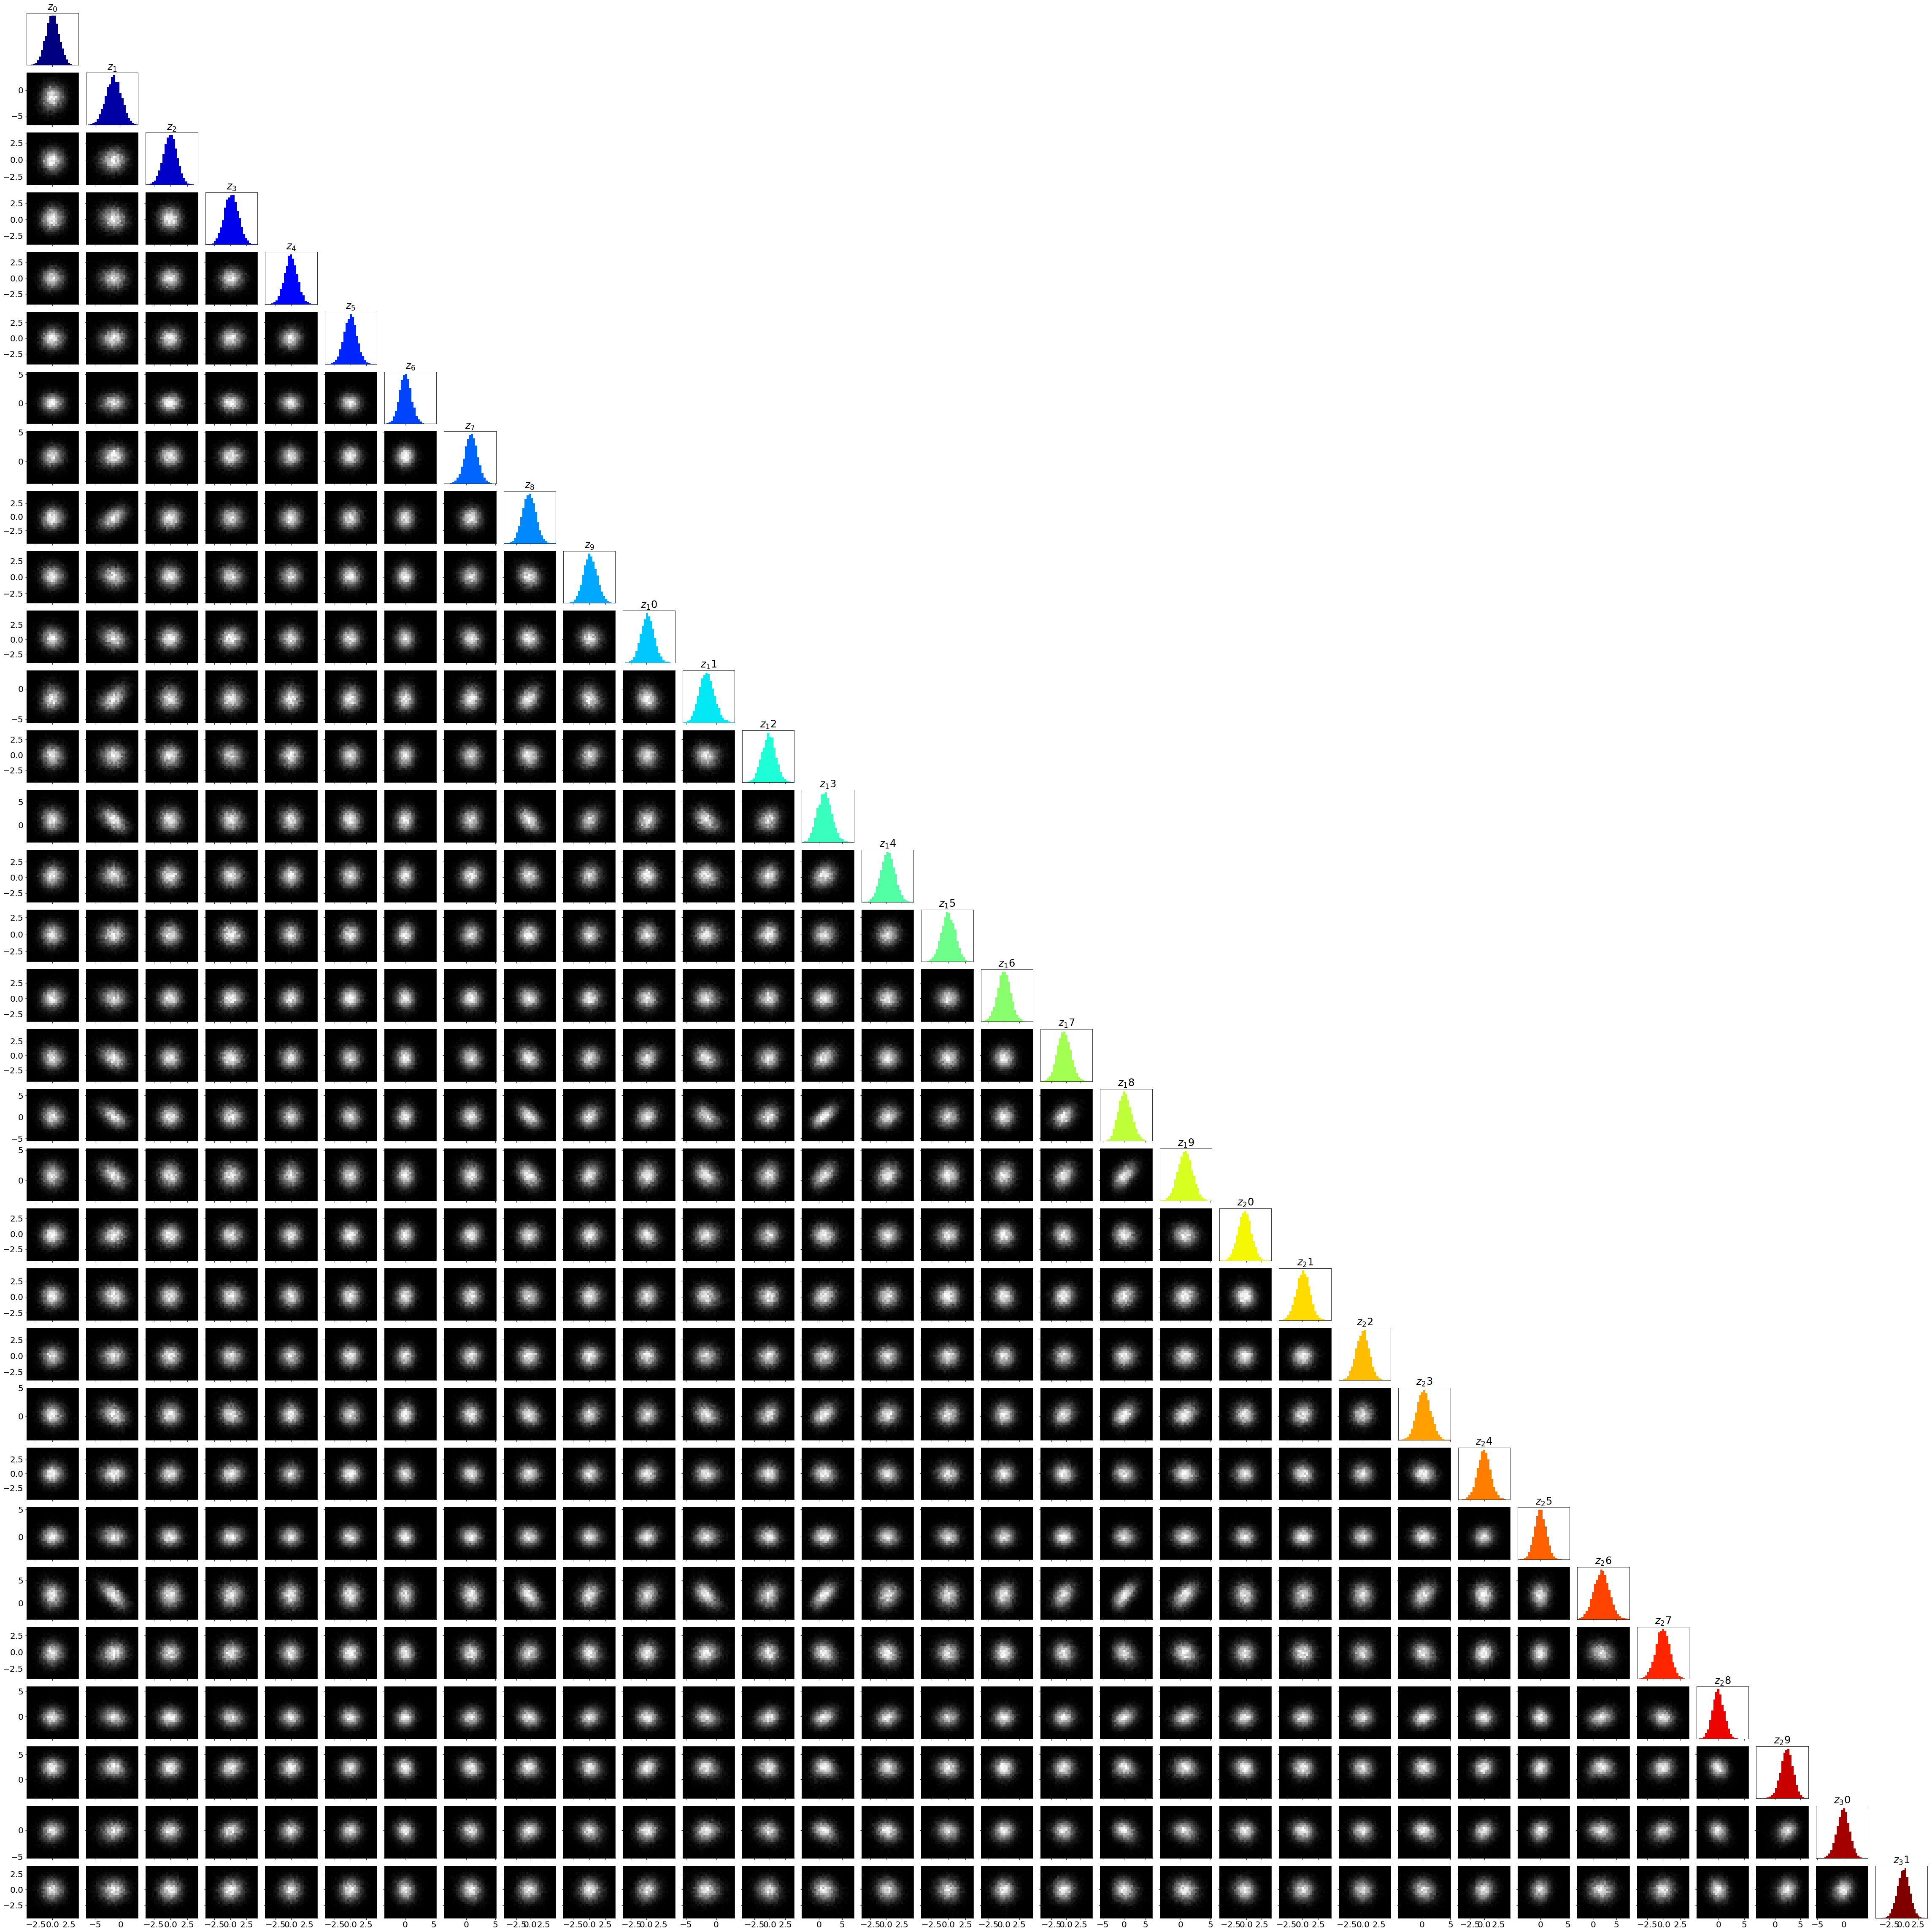

In [163]:
plot_corner_latent(z)

## LSST all filters

In [199]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

I= [6.48221069e+05, 4.36202878e+05, 2.27700000e+05, 4.66676013e+04,2.91513800e+02, 2.64974100e+03, 4.66828170e+03, 5.79938030e+03,5.72952590e+03, 3.50687710e+03]

ellipticities = []
e=[]
counts = 0

N = 100

lum_in_simple = np.empty([N,N,],dtype='float32')
lum_out_simple= np.empty([N,N,], dtype='float32')


for j in range(N):
    input_vae = batch_gen_lsst.__getitem__(2)
    output_vae = vae_lsst_conv.predict(input_vae[0], batch_size = batch_size)
    
    input_noisy = denorm(input_vae[0], bands_lsst, channel_last = True)
    input_noiseless = denorm(input_vae[1], bands_lsst, channel_last = True)
    output_vae = denorm (output_vae, bands_lsst, channel_last = True)
    
    for i in range (len(a[0])):
        try:
            gal_image = galsim.Image(input_noiseless[i][:,:,2])
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_in = [res.corrected_e1, res.corrected_e2]
            e_beta_in = [res.observed_shape.e, res.observed_shape.beta.rad]

            gal_image = galsim.Image(output_vae[i][:,:,2])
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_out = [res.corrected_e1, res.corrected_e2]
            e_beta_out = [res.observed_shape.e, res.observed_shape.beta.rad]

            ellipticities.append([e_in, e_out])
            e.append([e_beta_in, e_beta_out])
            
            # Measurement of fluxes
            mask = createCircularMask(64,64,None,5)
            masked_img_in_simple = input_noiseless[i][:,:,2].reshape((64,64)).copy()
            masked_img_in_simple[~mask] = 0  

            masked_img_out_simple = output_vae[i][:,:,2].reshape((64,64)).copy()
            masked_img_out_simple[~mask] = 0

            # Calculate the luminosity by substracting the noise
            lum_in_simple[j,i] = np.sum(masked_img_in_simple)
            lum_out_simple[j,i] = np.sum(masked_img_out_simple)


        except :
            print('erreur')
            counts+=1
            pass
        continue

ellipticities_LSST = np.array(ellipticities)
e_beta = np.array(e)
print('number of errors: '+str(counts))

number of errors: 0


### Shape plots

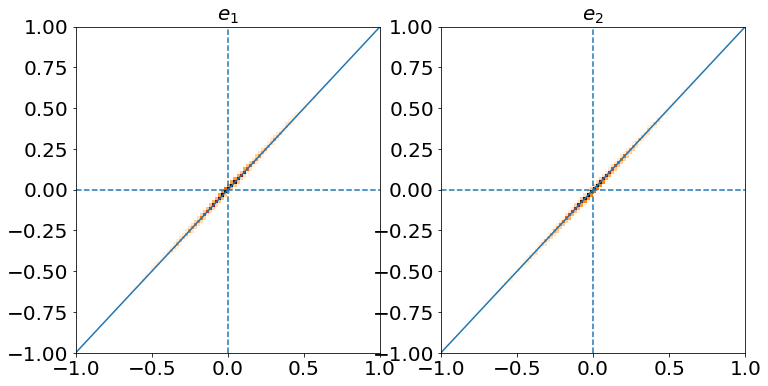

In [166]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(12,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_LSST[:,0,i], ellipticities_LSST[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1), fontsize=20)
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')
    axes[i].tick_params(axis='y')

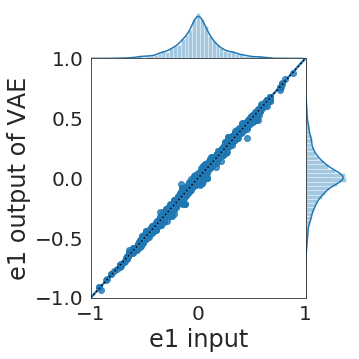

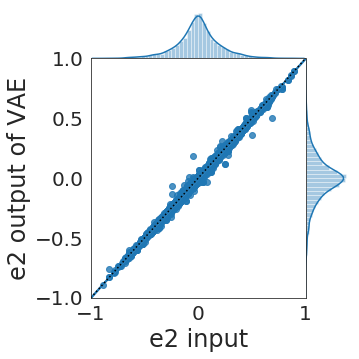

In [168]:
with sns.axes_style('white'):
            g = sns.jointplot(ellipticities_LSST[:,0,0], ellipticities_LSST[:,1,0], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

            g = sns.jointplot(ellipticities_LSST[:,0,1], ellipticities_LSST[:,1,1], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e2 input', 'e2 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

Text(0, 0.5, 'e of output galaxy')

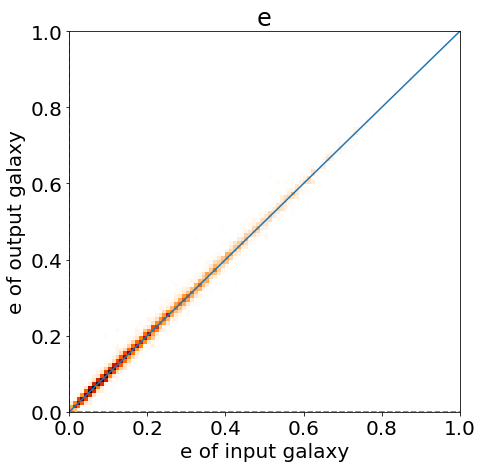

In [169]:
fig = plt.subplots(1,1, figsize=(7,7))
emax = 1
_ = plt.hist2d(e_beta[:,0,0], e_beta[:,1,0], bins=np.linspace(0,+emax,101), cmap=mpl.cm.gist_heat_r)
plt.plot([0,+emax],[0,+emax])
plt.axhline(y=0, ls='--')
plt.axvline(x=0, ls='--')
plt.title('e'.format(i+1),fontsize=24)# color="w", 
#plt.xaxis.label#.set_color('w')
plt.tick_params(axis='x')#, colors='w'
plt.tick_params(axis='y')#, colors='w'
plt.xlabel('e of input galaxy')
plt.ylabel('e of output galaxy')

Text(0, 0.5, 'beta of output galaxy')

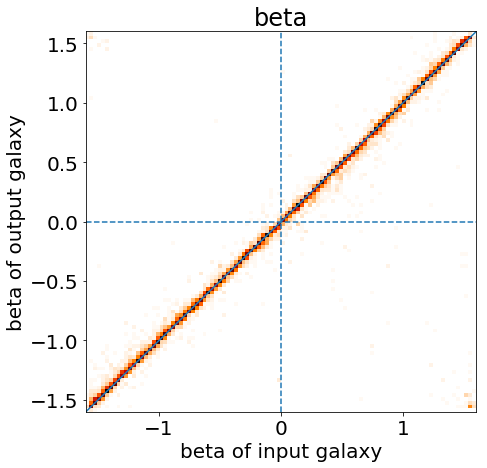

In [170]:
fig = plt.subplots(1,1, figsize=(7,7))
emax = 1.6
_ = plt.hist2d(e_beta[:,0,1], e_beta[:,1,1], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
plt.plot([-emax,+emax],[-emax,+emax])
plt.axhline(y=0, ls='--')
plt.axvline(x=0, ls='--')
plt.title('beta'.format(i+1),fontsize=24)# color="w", 
#plt.xaxis.label#.set_color('w')
plt.tick_params(axis='x')#, colors='w'
plt.tick_params(axis='y')#, colors='w'
plt.xlabel('beta of input galaxy')
plt.ylabel('beta of output galaxy')

### Luminosity plot

In [171]:
lum_in_simple = np.concatenate(lum_in_simple)
lum_out_simple = np.concatenate(lum_out_simple)

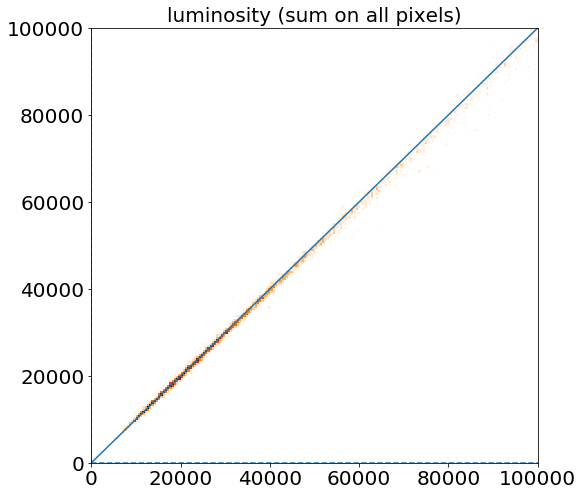

In [172]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = 100000
_ = axes.hist2d(lum_in_simple, lum_out_simple, bins=np.linspace(0,+emax,200), cmap=mpl.cm.gist_heat_r)
axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')

(0, 2000000)

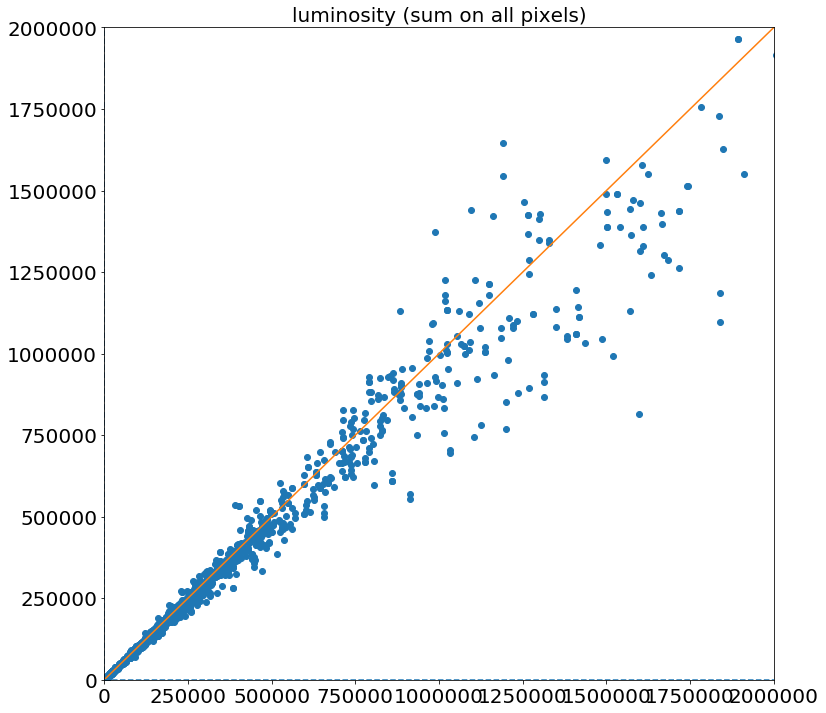

In [173]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(12,12))
emax = 2000000
axes.plot(lum_in_simple, lum_out_simple,'o')

axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlim(0,emax)
axes.set_ylim(0,emax)

(0, 200000)

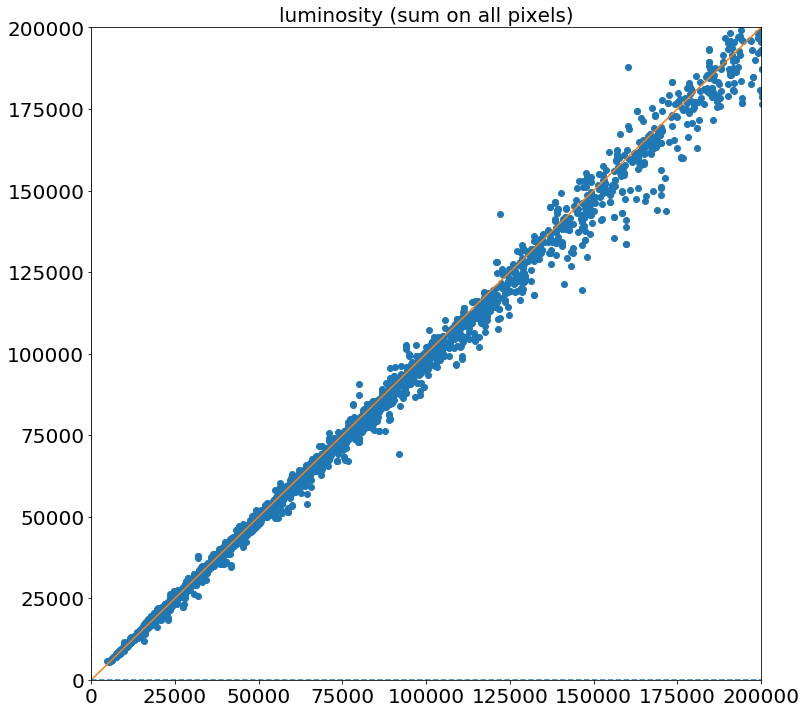

In [174]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(12,12))
emax = 200000
axes.plot(lum_in_simple, lum_out_simple,'o')

axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlim(0,emax)
axes.set_ylim(0,emax)

### Corner plot latent space

In [175]:
batch_size = 100
a = batch_gen_lsst.__getitem__(2)
output_enc = encoder_LSST.predict(a[0], batch_size = batch_size)
latent_dim =32
epsilon_std = 1.0

def sampling(args):
    z_mean, z_log_var = args
    epsilon = np.random.normal( 0.,
                              epsilon_std,(batch_size, latent_dim))
    return z_mean + np.exp(z_log_var / 2) * epsilon

z = []

In [176]:
for i in range (100):
    a = batch_gen_lsst.__getitem__(2)
    output_enc = encoder_LSST.predict(a[0], batch_size = batch_size)
    z.append(sampling(output_enc))


z = np.concatenate(z, axis = 0)

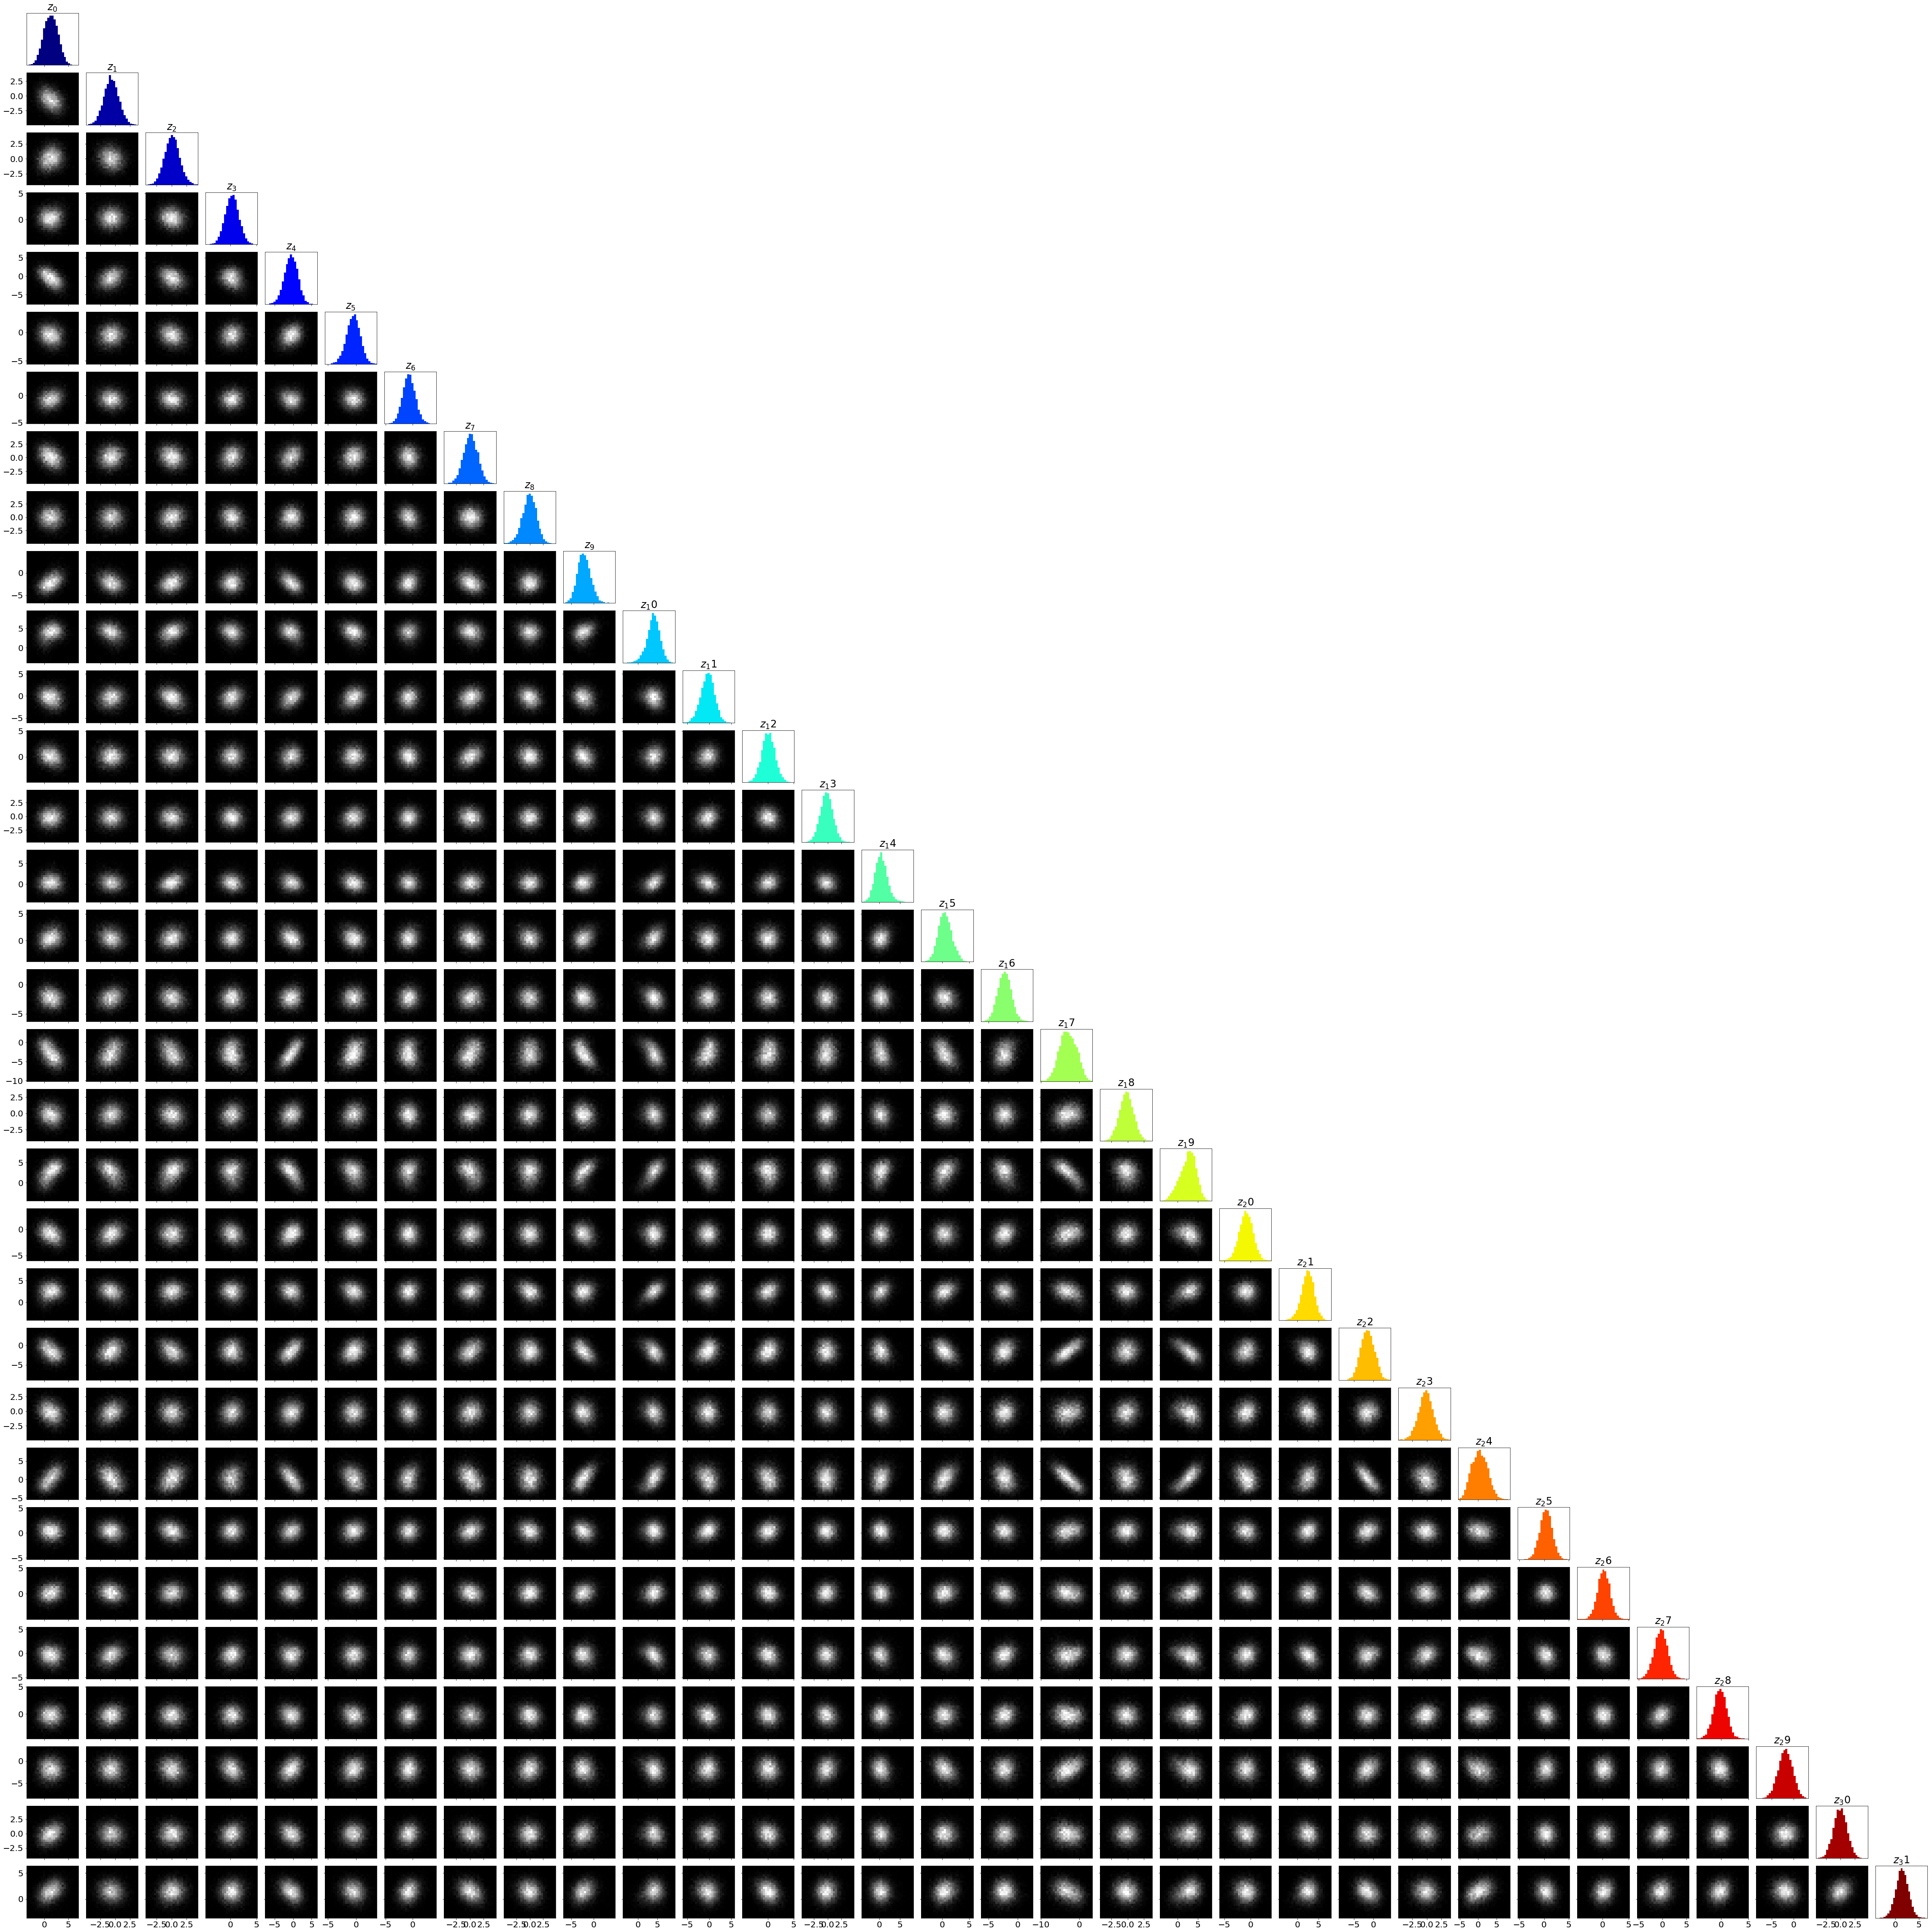

In [177]:
plot_corner_latent(z)

## LSST + Euclid all filters

In [180]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

I= [6.48221069e+05, 4.36202878e+05, 2.27700000e+05, 4.66676013e+04,2.91513800e+02, 2.64974100e+03, 4.66828170e+03, 5.79938030e+03,5.72952590e+03, 3.50687710e+03]
beta = 5

ellipticities = []
redshift_LSST=[]
e=[]
counts = 0


N = 100

lum_in_simple = np.empty([N,N,],dtype='float32')
lum_out_simple= np.empty([N,N,], dtype='float32')


for j in range(100):
    input_vae = batch_gen_lsst_euclid.__getitem__(2)
    output_vae = vae_lsst_euclid_conv.predict(input_vae[0], batch_size = batch_size)
    
    input_noisy = denorm(input_vae[0], bands_lsst_euclid, channel_last = True)
    input_noiseless = denorm(input_vae[1], bands_lsst_euclid, channel_last = True)
    output_vae = denorm (output_vae, bands_lsst_euclid, channel_last = True)
    
    for i in range (len(a[0])):
        try:

            gal_image = galsim.Image(input_noiseless[i][:,:,6])
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_in = [res.corrected_e1, res.corrected_e2]
            e_beta_in = [res.observed_shape.e, res.observed_shape.beta.rad]

            gal_image = galsim.Image(output_vae[i][:,:,6])
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_out = [res.corrected_e1, res.corrected_e2]
            e_beta_out = [res.observed_shape.e, res.observed_shape.beta.rad]

            ellipticities.append([e_in, e_out])
            e.append([e_beta_in, e_beta_out])


            # Measurement of fluxes
            mask = createCircularMask(64,64,None,5)
            masked_img_in_simple = input_noiseless[i][:,:,6].copy()
            masked_img_in_simple[~mask] = 0  

            masked_img_out_simple = output_vae[i][:,:,6].copy()
            masked_img_out_simple[~mask] = 0

            # Calculate the luminosity by substracting the noise
            lum_in_simple[j,i] = np.sum(masked_img_in_simple)
            lum_out_simple[j,i] = np.sum(masked_img_out_simple)
          
                    
        except :
            print('erreur')
            counts+=1
            pass
        continue

ellipticities_LSST_euclid = np.array(ellipticities)
e_beta_LSST_euclid = np.array(e)
print('number of errors: '+str(counts))

number of errors: 0


### Shape plots

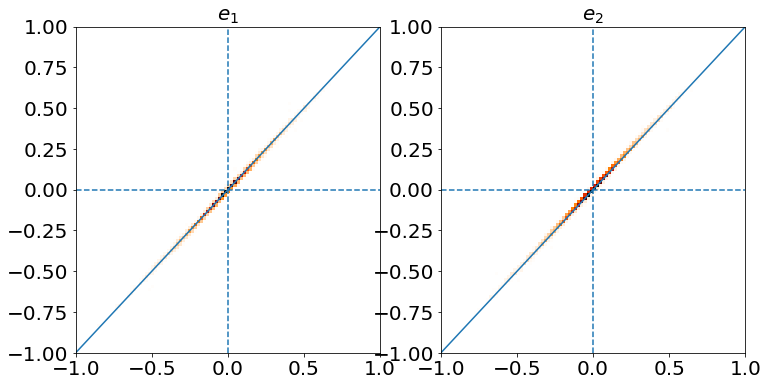

In [181]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(12,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_LSST_euclid[:,0,i], ellipticities_LSST_euclid[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1), fontsize=20)#, color="w"
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w')
    axes[i].tick_params(axis='y')#, colors='w')

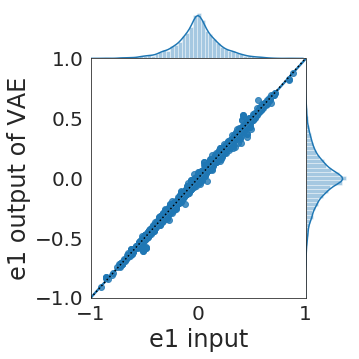

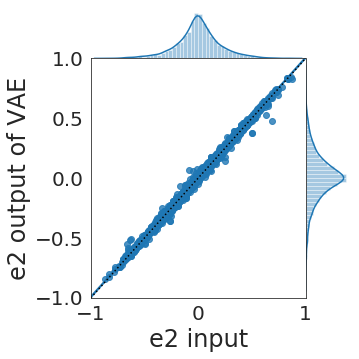

In [182]:
with sns.axes_style('white'):
            g = sns.jointplot(ellipticities_LSST_euclid[:,0,0], ellipticities_LSST_euclid[:,1,0], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

            g = sns.jointplot(ellipticities_LSST_euclid[:,0,1], ellipticities_LSST_euclid[:,1,1], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e2 input', 'e2 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

Text(0, 0.5, 'e of output galaxy')

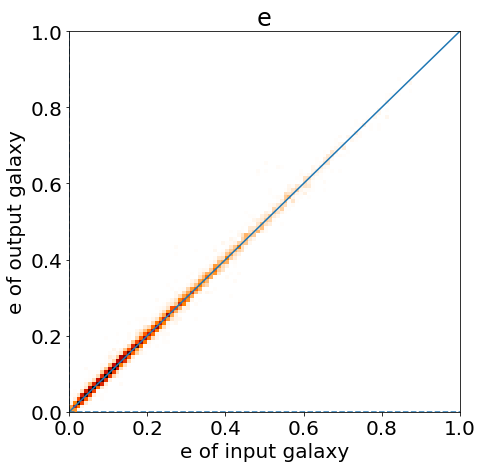

In [183]:
fig = plt.subplots(1,1, figsize=(7,7))
emax = 1
_ = plt.hist2d(e_beta_LSST_euclid[:,0,0], e_beta_LSST_euclid[:,1,0], bins=np.linspace(0,+emax,101), cmap=mpl.cm.gist_heat_r)
plt.plot([0,+emax],[0,+emax])
plt.axhline(y=0, ls='--')
plt.axvline(x=0, ls='--')
plt.title('e'.format(i+1),fontsize=24)# color="w", 
#plt.xaxis.label#.set_color('w')
plt.tick_params(axis='x')#, colors='w'
plt.tick_params(axis='y')#, colors='w'
plt.xlabel('e of input galaxy')
plt.ylabel('e of output galaxy')

Text(0, 0.5, 'beta of output galaxy')

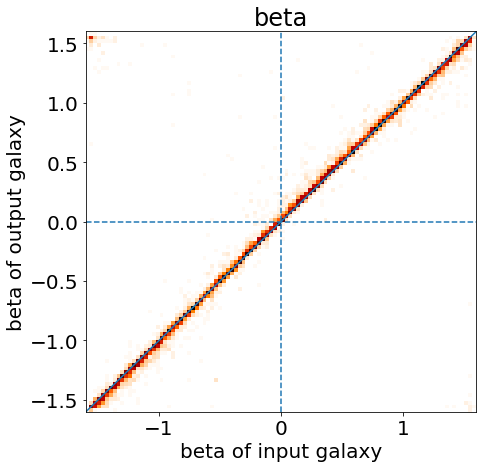

In [184]:
fig = plt.subplots(1,1, figsize=(7,7))
emax = 1.6
_ = plt.hist2d(e_beta_LSST_euclid[:,0,1], e_beta_LSST_euclid[:,1,1], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
plt.plot([-emax,+emax],[-emax,+emax])
plt.axhline(y=0, ls='--')
plt.axvline(x=0, ls='--')
plt.title('beta'.format(i+1),fontsize=24)# color="w", 
#plt.xaxis.label#.set_color('w')
plt.tick_params(axis='x')#, colors='w'
plt.tick_params(axis='y')#, colors='w'
plt.xlabel('beta of input galaxy')
plt.ylabel('beta of output galaxy')

### Luminosity plots

In [185]:
lum_in_simple = np.concatenate(lum_in_simple)
lum_out_simple = np.concatenate(lum_out_simple)

In [186]:
lum_in_simple.shape, lum_out_simple.shape

((10000,), (10000,))

In [187]:
print(lum_in_simple[0], lum_out_simple[0])

18236.453 18029.254


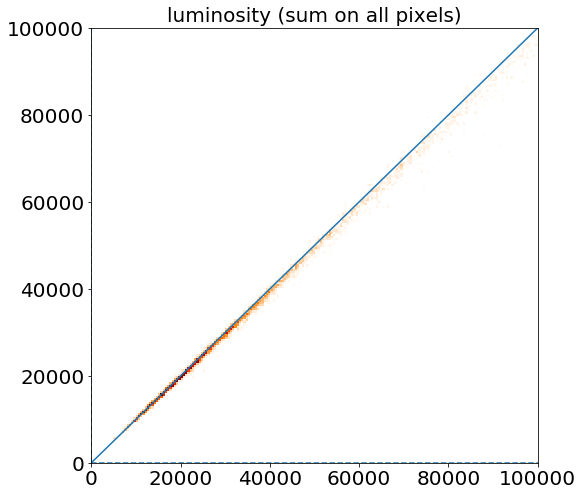

In [189]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = 100000
_ = axes.hist2d(lum_in_simple, lum_out_simple, bins=np.linspace(0,+emax,200), cmap=mpl.cm.gist_heat_r)
axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')

(0, 2000000)

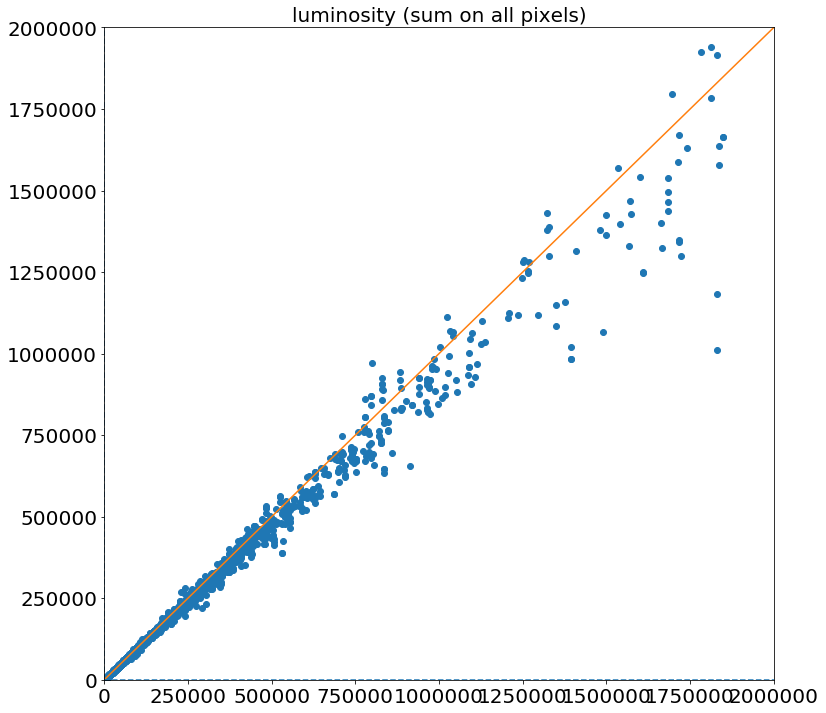

In [190]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(12,12))
emax = 2000000
axes.plot(lum_in_simple, lum_out_simple,'o')

axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlim(0,emax)
axes.set_ylim(0,emax)

(0, 200000)

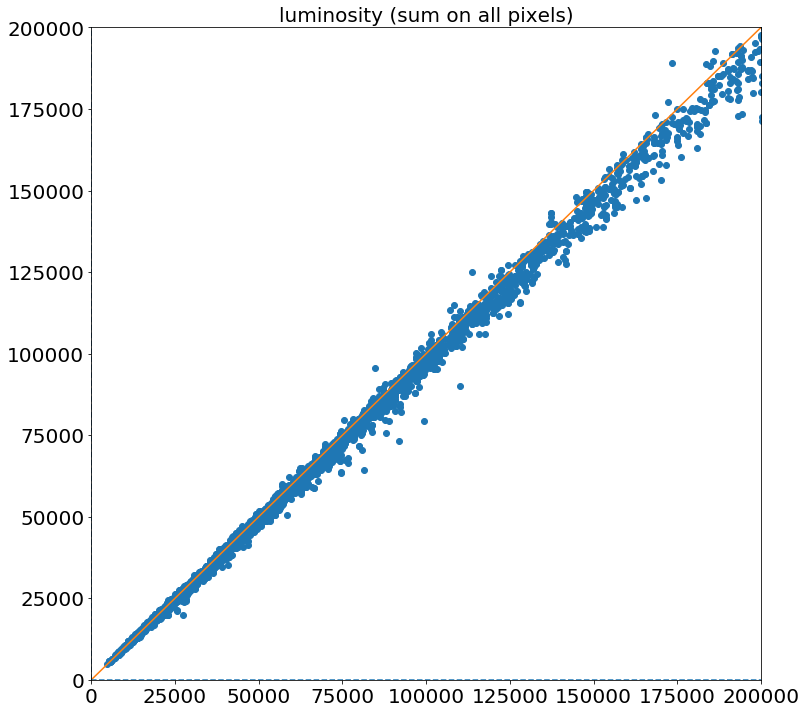

In [191]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(12,12))
emax = 200000
axes.plot(lum_in_simple, lum_out_simple,'o')

axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlim(0,emax)
axes.set_ylim(0,emax)

### Corner plot latent space

In [192]:
latent_dim =32
epsilon_std = 1.0

a = batch_gen_lsst_euclid.__getitem__(2)
output_enc = encoder_LSST_EUCLID.predict(a[0], batch_size = batch_size)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = np.random.normal( 0.,
                              epsilon_std,(batch_size, latent_dim))
    return z_mean + np.exp(z_log_var / 2) * epsilon

In [193]:
z = []
for i in range (100):
    a = batch_gen_lsst_euclid.__getitem__(2)
    output_enc = encoder_LSST_EUCLID.predict(a[0], batch_size = batch_size)
    z.append(sampling(output_enc))

z = np.concatenate(z, axis = 0)

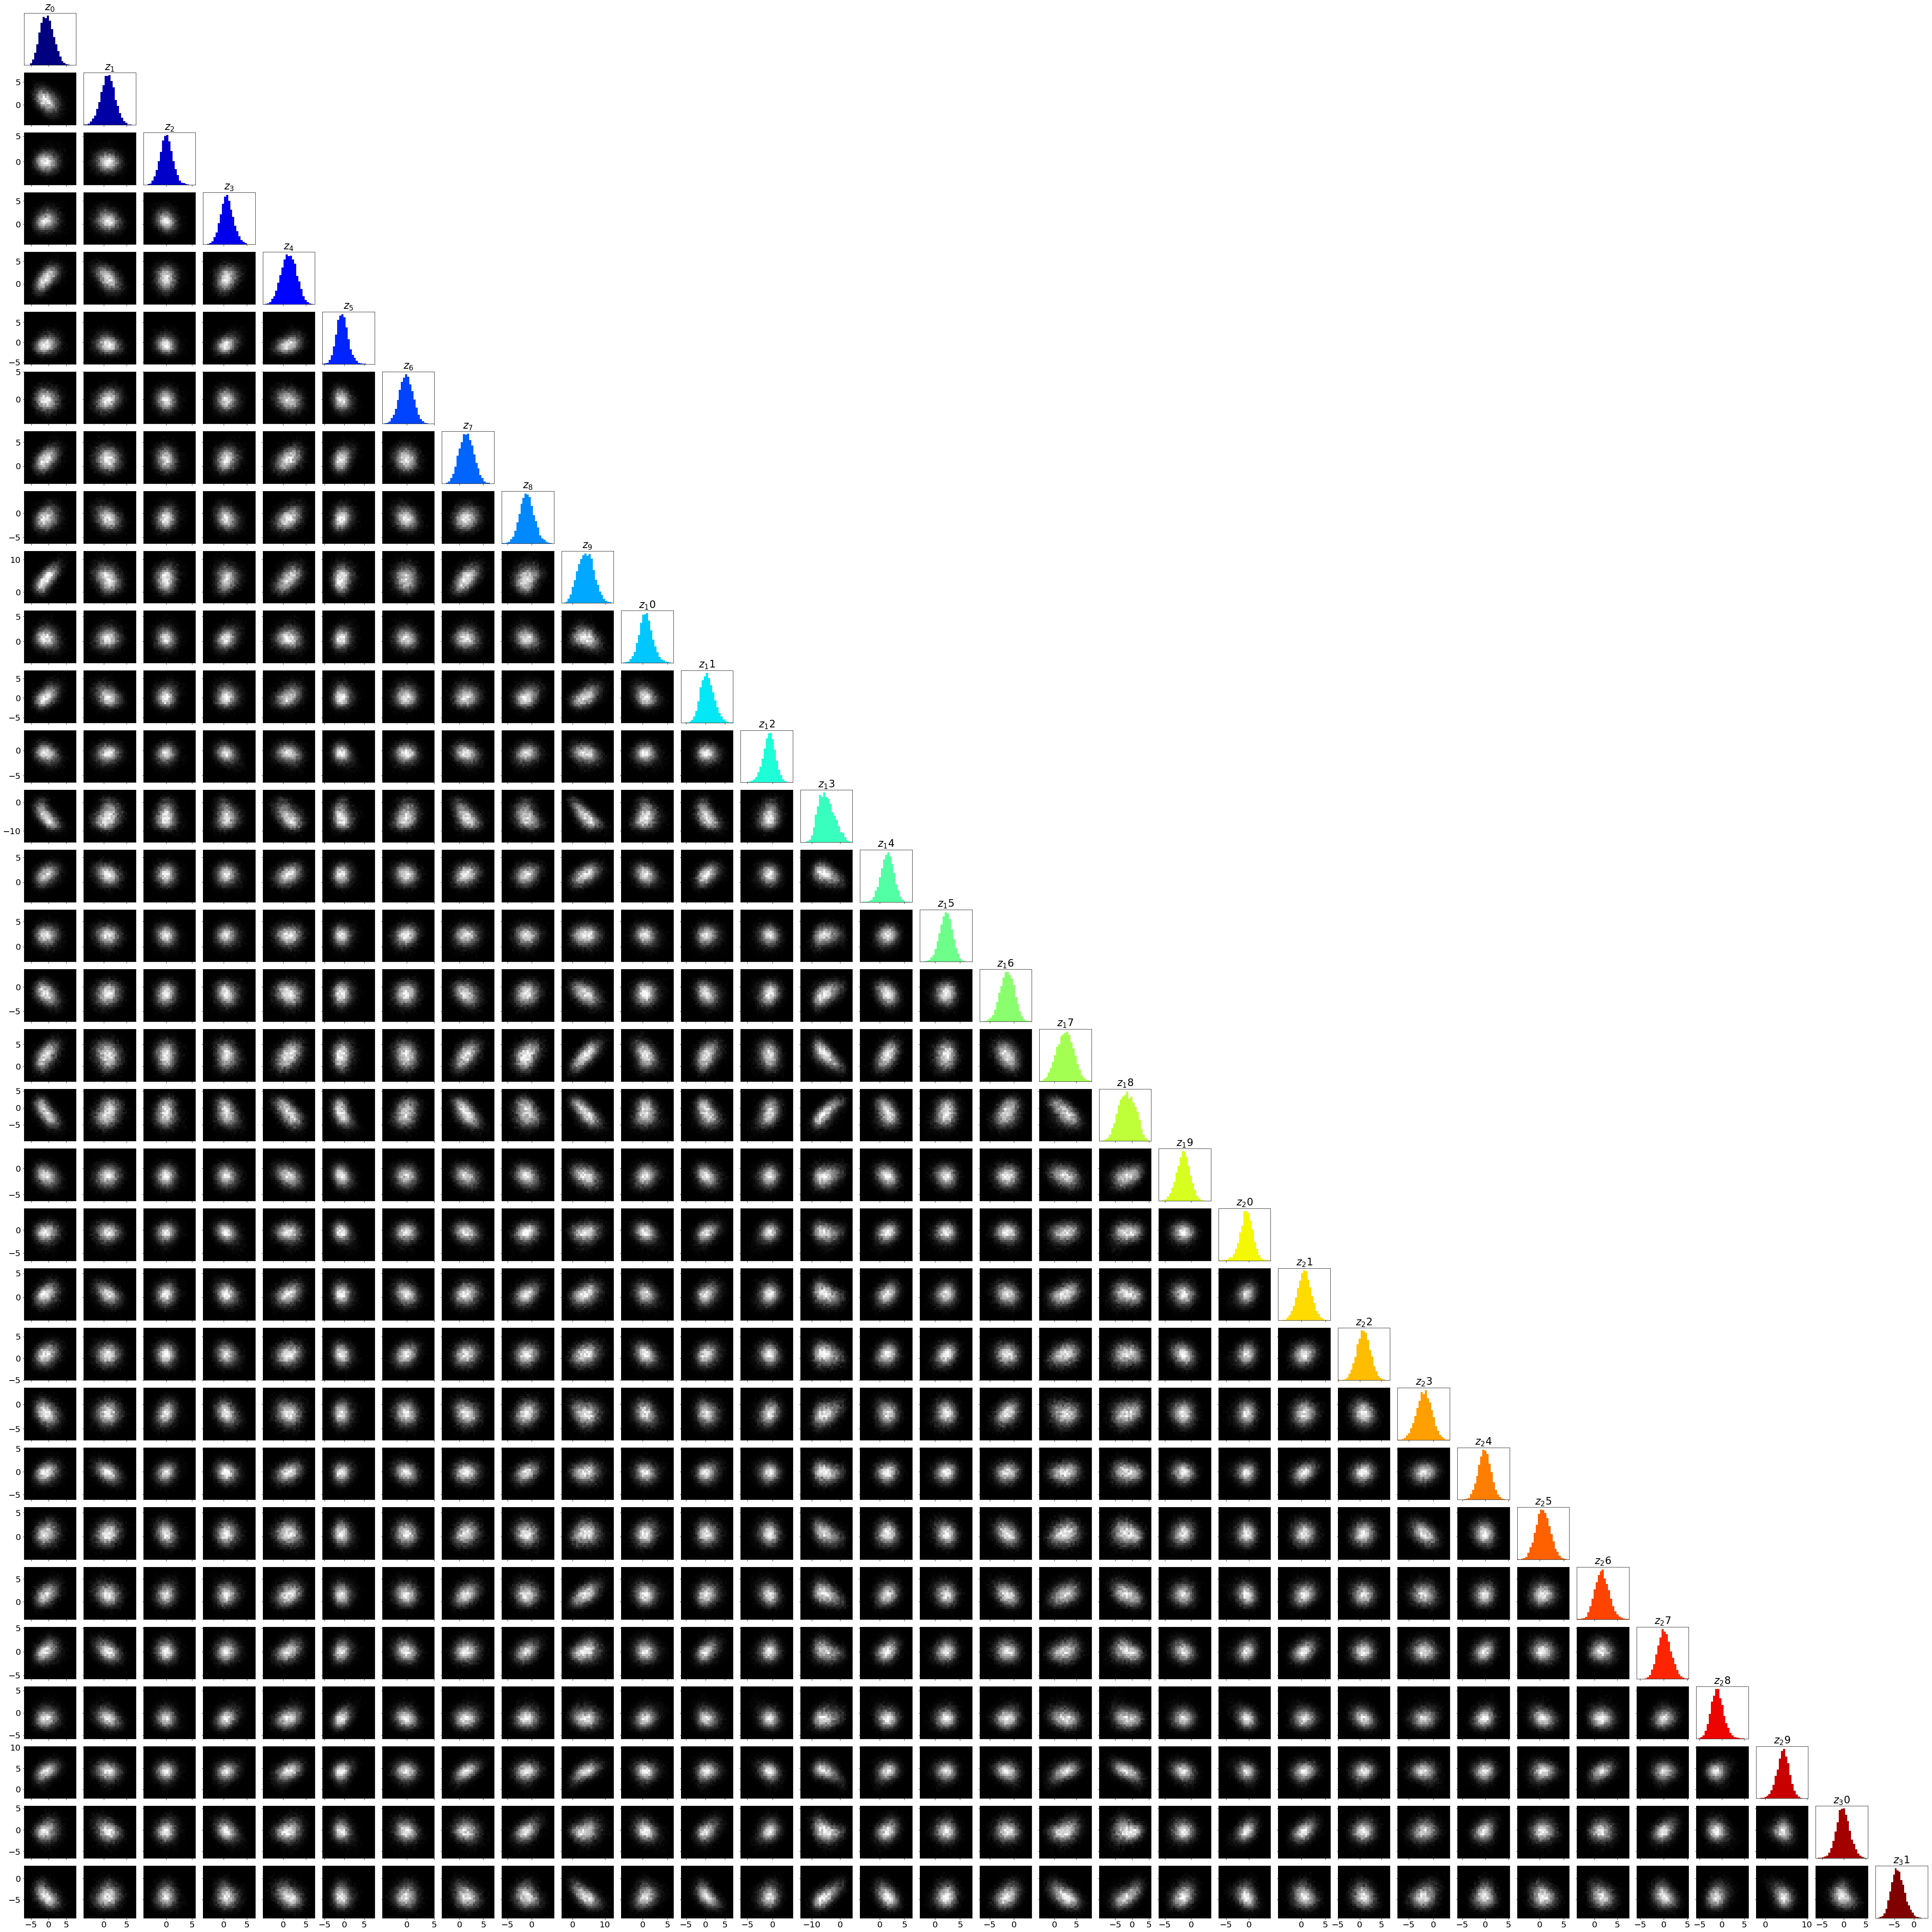

In [194]:
plot_corner_latent(z)

### N sampling of different galaxies for LSST only

In [206]:
# define the number of samplings
N = 3
nb_of_samplings = 10

batch_size = 100

In [207]:
# Define the PSF used for measurement
PSF = galsim.Moffat(fwhm=0.1, beta=2.5)
final_epsf_image = PSF.drawImage(scale=0.2)

0
0
1
2
3
4
5
6
7
8
9
1
0
1
2
3
4
5
6
7
8
9
2
0
1
2
3
4
5
6
7
8
9
0


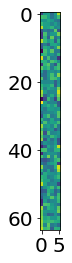

In [208]:
res_out_lsst_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

gal = []
err_count = 0

for i in range (N):
    list_galsim_simple=batch_gen_lsst.__getitem__(2)
    gal.append(list_galsim_simple[0][0])
    
    plt.imshow(list_galsim_simple[0][0][2])#
    for k in range (len(list_galsim_simple[0])):
        list_galsim_simple[0][k] = gal[i]
    try: 
        print(i)
        for j in range (nb_of_samplings):
            print(j)
            output_vae_list_lsst = vae_lsst_conv.predict(list_galsim_simple[0][:,:,:], batch_size = batch_size)
            output_vae_list_lsst = output_vae_list_lsst

            for t in range (batch_size):

                img_out_simple = galsim.Image(output_vae_list_lsst[t][:,:,2])
                res_out_lsst_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                res_out_lsst_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2
                res_out_lsst_e[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e   
            
    except :
        err_count +=1
        print('erreur')
        pass
    continue
            
print(err_count)

In [209]:
res_in_e1 = np.empty([N], dtype='float32')
res_in_e2 = np.empty([N], dtype='float32')
res_in_e = np.empty([N], dtype='float32')

for k in range (N):
#    try: 
    img_in_simple = galsim.Image(gal[k][:,:,2])
    res_in_e1[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e1
    res_in_e2[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e2
    res_in_e[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e
    print(res_in_e1[k], res_in_e2[k])

-0.25047645 0.18052663
0.17008698 0.52309346
0.4438768 -0.38680986


In [212]:
res_out_lsst_e1[0].shape

(1000,)

In [213]:
print(res_out_lsst_e1[0])

[-0.18447208 -0.18449241 -0.18446082 -0.18447289 -0.18446186 -0.18447557
 -0.18448028 -0.18446854 -0.18448225 -0.18446846 -0.18447912 -0.18447606
 -0.18447474 -0.18447919 -0.18447182 -0.18448254 -0.18447627 -0.18448938
 -0.18447772 -0.18448065 -0.18447733 -0.18447651 -0.18448402 -0.18446894
 -0.18447682 -0.18447159 -0.18446802 -0.18447931 -0.18446642 -0.18446642
 -0.18447495 -0.18447995 -0.18446834 -0.18446486 -0.18447757 -0.18446349
 -0.18447365 -0.18448123 -0.1844729  -0.18446875 -0.18448153 -0.18447247
 -0.18447359 -0.18446425 -0.18446922 -0.18446897 -0.18445714 -0.18448155
 -0.18446906 -0.18447211 -0.18447646 -0.1844626  -0.18447177 -0.18446463
 -0.18446971 -0.18446468 -0.18446802 -0.18447246 -0.18447086 -0.18446694
 -0.18446958 -0.18447332 -0.18447194 -0.1844583  -0.18446454 -0.18448395
 -0.18447031 -0.18448596 -0.18447444 -0.18447559 -0.18446574 -0.18447776
 -0.18447849 -0.18447527 -0.18446936 -0.18447314 -0.18447153 -0.18446647
 -0.18447632 -0.18446259 -0.18447655 -0.18447727 -0

In [ ]:
_ = plt.hist()

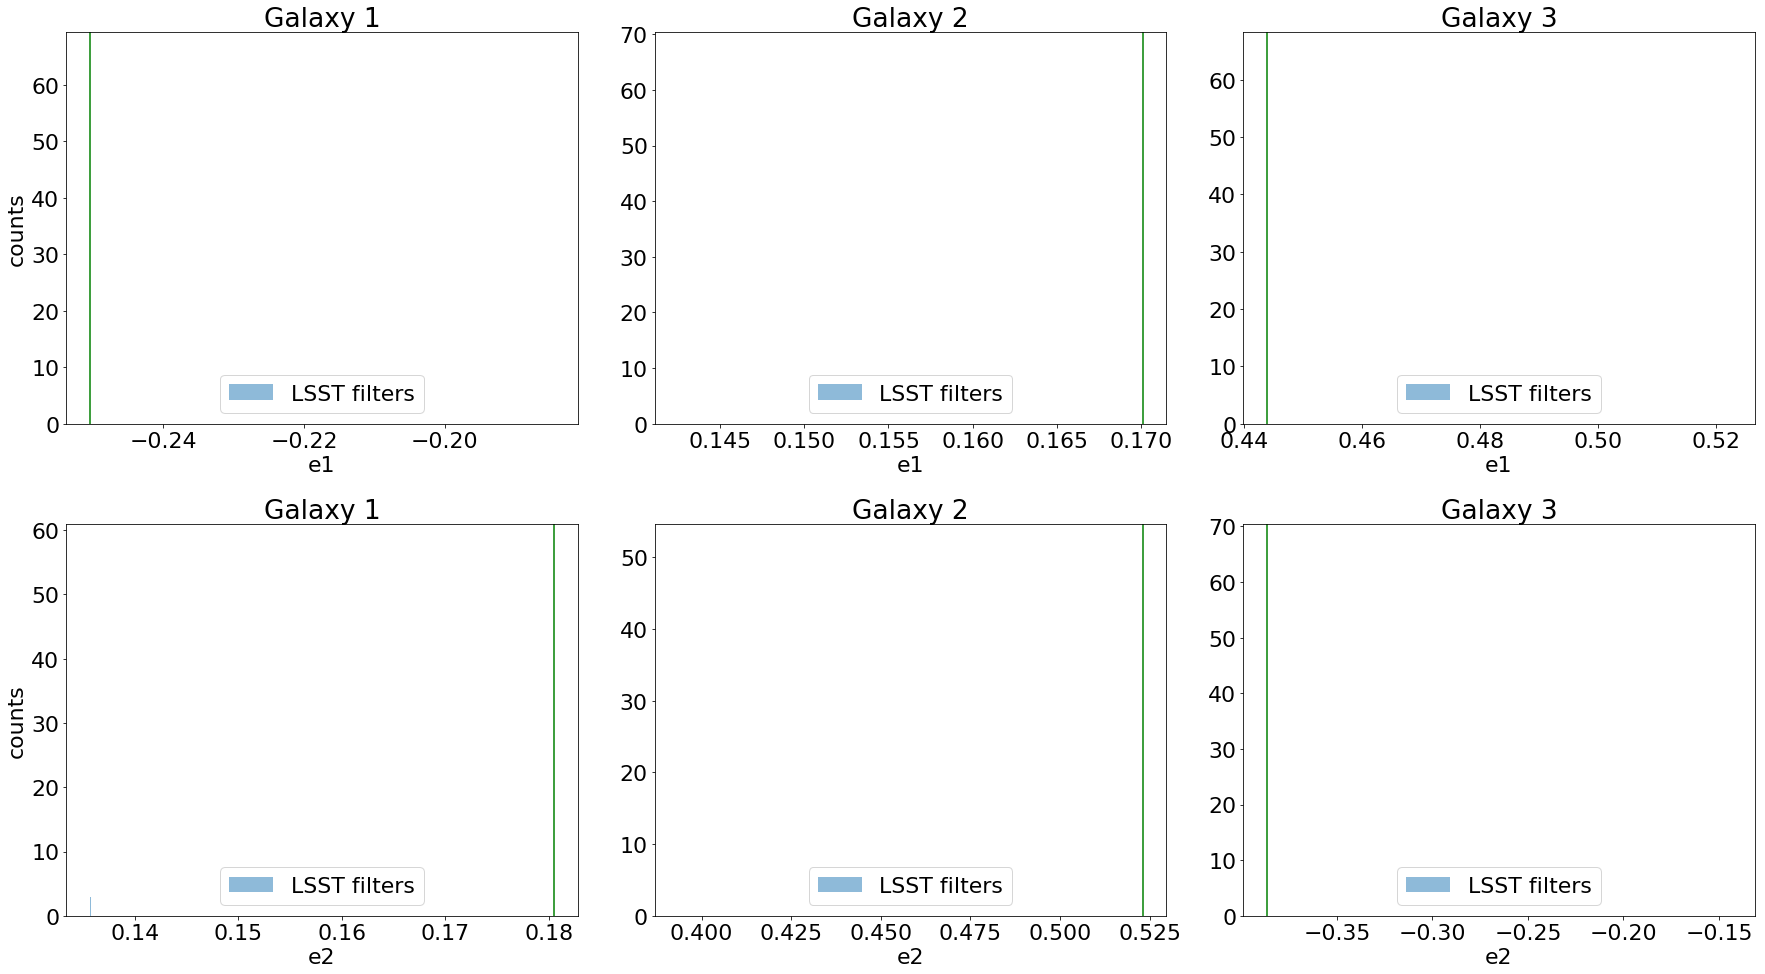

In [214]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(2,3, figsize=(25,14))

ax = axes[0,0]
_ = ax.hist(res_out_lsst_e1[0], bins = 50,label ='LSST filters' ,  alpha = 0.5)
x = np.linspace(min(res_out_lsst_e1[0]), max(res_out_lsst_e1[0]), 100)
#ax.plot(x, mlab.normpdf(x, mean, sigma))


ax.axvline(res_in_e1[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e1')
ax.legend()

ax = axes[0,1]
_ = ax.hist(res_out_lsst_e1[1] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e1[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e1')
ax.legend()

ax = axes[0,2]
_ = ax.hist(res_out_lsst_e1[2] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e1[2],color='g')
ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e1')
ax.legend()

ax = axes[1,0]
_ = ax.hist(res_out_lsst_e2[0] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e2[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,1]
_ = ax.hist(res_out_lsst_e2[1] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e2[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,2]
_ = ax.hist(res_out_lsst_e2[2] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e2[2],color='g')

ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e2')
ax.legend()

plt.tight_layout()

[]

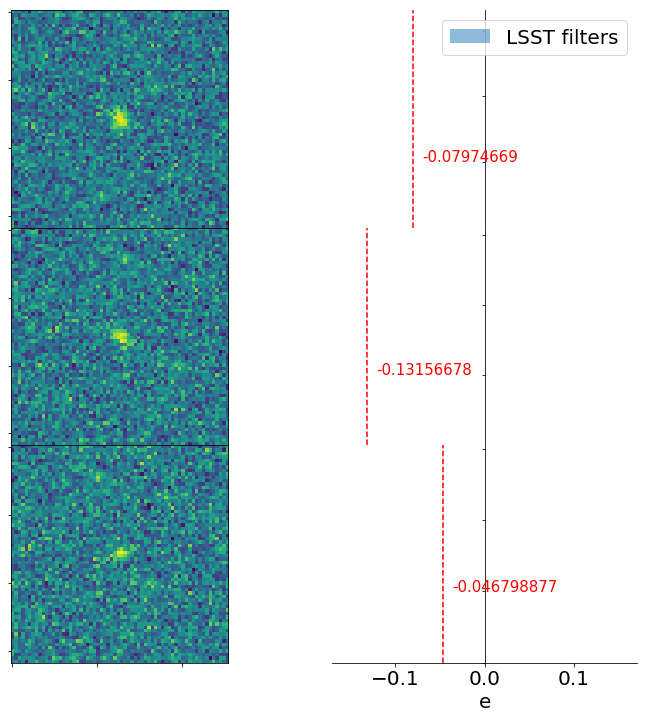

In [211]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)



fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0)

max_x = np.max((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
min_x = np.min((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
max_lim = np.max((np.abs(max_x), np.abs(min_x)))


ax = axes[0,0]
_ = ax.imshow(gal[0][:,:,2])
#ax.axis('off')
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[0,1]
_ = ax.hist(res_out_lsst_e[0]- res_in_e[0], bins = 50, label ='LSST filters' , alpha = 0.5)
ax.axvline(np.mean(res_out_lsst_e[0]-res_in_e[0]),color='r',ls='--')
ax.text(np.mean(res_out_lsst_e[0]-res_in_e[0])+0.01, 20, str(np.mean(res_out_lsst_e[0]-res_in_e[0])), fontsize =15, color='r')
ax.set_xlabel('e')
ax.legend()
ax.set_xlim(-max_lim, max_lim)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])

ax = axes[1,0]
_ = ax.imshow(gal[1][:,:,2])
#ax.axis('off')
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,1]
_ = ax.hist(res_out_lsst_e[1]- res_in_e[1], bins = 50, label ='LSST filters' , alpha = 0.5)
ax.axvline(np.mean(res_out_lsst_e[1]-res_in_e[1]),color='r',ls='--')
ax.text(np.mean(res_out_lsst_e[1]-res_in_e[1])+0.01, 20, str(np.mean(res_out_lsst_e[1]-res_in_e[1])), fontsize =15, color='r')
ax.set_xlabel('e')
ax.set_xlim(-max_lim, max_lim)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])

ax = axes[2,0]
_ = ax.imshow(gal[2][:,:,2])
#ax.axis('off')
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,1]
_ = ax.hist(res_out_lsst_e[2]-res_in_e[2] , bins = 50, label ='LSST filters' , alpha = 0.5)
ax.axvline(np.mean(res_out_lsst_e[2]-res_in_e[2]),color='r',ls='--')
ax.text(np.mean(res_out_lsst_e[2]-res_in_e[2])+0.01, 20, str(np.mean(res_out_lsst_e[2]-res_in_e[2])), fontsize =15, color='r')
ax.set_xlabel('e')
ax.set_xlim(-max_lim, max_lim)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_yticklabels([])


In [ ]:
res_out_r_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_r_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')


gal = []
err_count = 0

for i in range (N):
    list_galsim_simple=batch_gen_lsst_euclid.__getitem__(2)
    gal.append(list_galsim_simple[0][0])
    
    plt.imshow(list_galsim_simple[0][0].reshape((10,64,64))[6])#
    for k in range (len(list_galsim_simple[0])):
        list_galsim_simple[0][k] = gal[i]
    try: 
        print(i)
        for j in range (nb_of_samplings):
            print(j)
            output_vae_list_r = vae_lsst_r_band_conv.predict(list_galsim_simple[0].reshape((batch_size,10,64,64))[:,6].reshape((batch_size,64,64,1)), batch_size = batch_size)
            output_vae_list_r = output_vae_list_r.reshape((batch_size,64,64))

            output_vae_list_lsst = vae_lsst_conv.predict(list_galsim_simple[0].reshape((batch_size,10,64,64))[:,4:].reshape((batch_size,64,64,6)), batch_size = batch_size)
            output_vae_list_lsst = output_vae_list_lsst.reshape((batch_size,6,64,64))

            output_vae_list_lsst_euclid = vae_lsst_euclid_conv.predict(list_galsim_simple[0], batch_size = batch_size)
            output_vae_list_lsst_euclid = output_vae_list_lsst_euclid.reshape((batch_size,10,64,64))

            for t in range (batch_size):
                img_out_simple = galsim.Image(output_vae_list_r[t])
                res_out_r_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                res_out_r_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2

                img_out_simple = galsim.Image(output_vae_list_lsst[t,2])
                res_out_lsst_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                res_out_lsst_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2

                img_out_simple = galsim.Image(output_vae_list_lsst_euclid[t,6])
                res_out_lsst_euclid_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                res_out_lsst_euclid_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2
#print(res_out[i,j*batch_size+t])

            
            
    except :
        err_count +=1
        print('erreur')
        pass
    continue
            
print(err_count)

0
0
1
2
3
4
5
6
7
8
9
1
0
1
2
3
4


In [ ]:
res_in_e1 = np.empty([N], dtype='float32')
res_in_e2 = np.empty([N], dtype='float32')

for k in range (N):
#    try: 
    img_in_simple = galsim.Image(gal[k].reshape((10,64,64))[6])
    res_in_e1[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e1
    res_in_e2[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e2
    print(res_in_e1[k], res_in_e2[k])

In [ ]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(2,3, figsize=(25,14))

ax = axes[0,0]
_ = ax.hist(res_out_r_e1[0],  bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e1[0], bins = 50,label ='LSST filters' ,  alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e1[0], bins = 50,label = 'LSST+Euclid \n filters' ,  alpha = 0.5)
variance = np.var(res_out_r_e1[0])
sigma = np.sqrt(variance)
x = np.linspace(min(res_out_r_e1[0]), max(res_out_r_e1[0]), 100)
#ax.plot(x, mlab.normpdf(x, mean, sigma))


ax.axvline(res_in_e1[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e1')
ax.legend()

ax = axes[0,1]
_ = ax.hist(res_out_r_e1[1] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e1[1] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e1[1] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e1[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e1')
ax.legend()

ax = axes[0,2]
_ = ax.hist(res_out_r_e1[2] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e1[2] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e1[2] , bins = 50,label = 'LSST+Euclid \n filters' ,  alpha = 0.5)

ax.axvline(res_in_e1[2],color='g')
ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e1')
ax.legend()

ax = axes[1,0]
_ = ax.hist(res_out_r_e2[0] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e2[0] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e2[0] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e2[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,1]
_ = ax.hist(res_out_r_e2[1] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e2[1] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e2[1] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e2[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,2]
_ = ax.hist(res_out_r_e2[2] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e2[2] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e2[2] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e2[2],color='g')
ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e2')
ax.legend()

plt.tight_layout()

In [ ]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(2, 2, figsize=(16, 12))
_ = axes[0,0].hist(ellipticities_test[:,0,0], bins = 100 , histtype='stepfilled')
axes[0,0].set_title('e1 distribution LSST')
axes[0,0].set_ylim(0, 65)
_ = axes[0,1].hist(ellipticities_test[:,1,0], bins = 100 , histtype='stepfilled')
axes[0,1].set_title('e1 distribution VIS (Euclid)')
axes[0,1].set_ylim(0, 65)
_ = axes[1,0].hist(ellipticities_test[:,0,1], bins = 100 , histtype='stepfilled')
axes[1,0].set_title('e2 distribution LSST')
axes[1,0].set_ylim(0, 65)
_ = axes[1,1].hist(ellipticities_test[:,1,1], bins = 100 , histtype='stepfilled')
axes[1,1].set_title('e2 distribution VIS (Euclid)')
axes[1,1].set_ylim(0, 65)

## Comparison with VAE R filter only

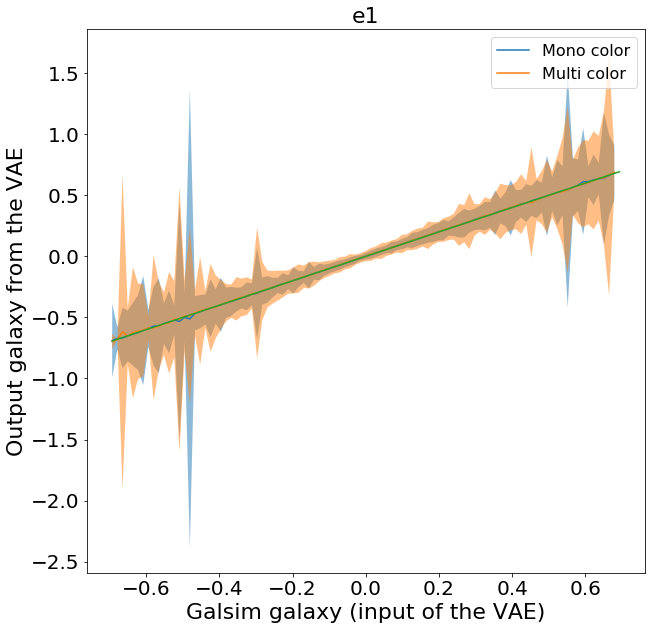

In [200]:
plt.figure(figsize=(10,10))

bins = np.linspace(-0.7, 0.7, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(ellipticities_r_band[:,0,0],ellipticities_r_band[:,1,0],bins)
mean_multi, var_multi = mean_var(ellipticities_LSST[:,0,0],ellipticities_LSST[:,1,0],bins)

plt.plot(mid, mean_simple, label = 'Mono color')
plt.plot(mid, mean_multi, label = 'Multi color')
plt.fill_between(mid, mean_simple - 100*var_simple**0.5, mean_simple + 100*var_simple**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 100*var_multi**0.5, mean_multi + 100*var_multi**0.5, alpha=0.5)
plt.ylabel('Output galaxy from the VAE', fontsize = 22)
plt.xlabel('Galsim galaxy (input of the VAE)', fontsize = 22)
plt.title('e1', fontsize = 22)
plt.legend(fontsize = 16)

plt.plot(mid, mid)

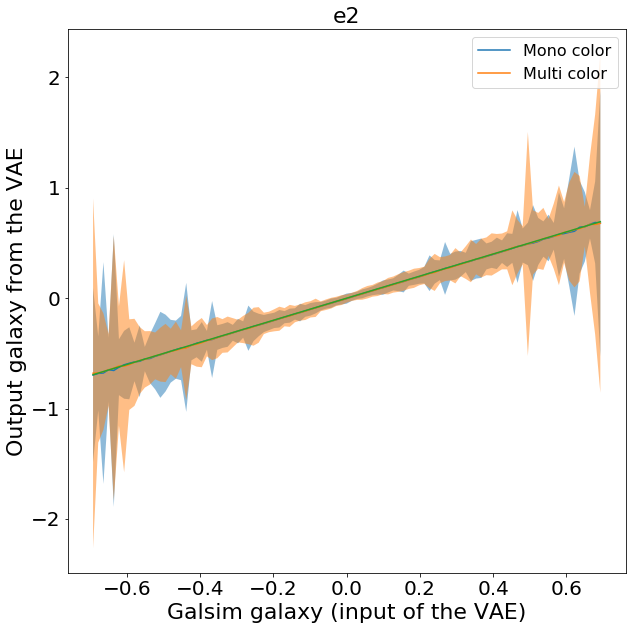

In [201]:
plt.figure(figsize=(10,10))

bins = np.linspace(-0.7, 0.7, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(ellipticities_r_band[:,0,1],ellipticities_r_band[:,1,1],bins)
mean_multi, var_multi = mean_var(ellipticities_LSST[:,0,1],ellipticities_LSST[:,1,1],bins)

plt.plot(mid, mean_simple, label = 'Mono color')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'Multi color')
plt.fill_between(mid, mean_simple - 100*var_simple**0.5, mean_simple + 100*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 100*var_multi**0.5, mean_multi + 100*var_multi**0.5, alpha=0.5)
plt.ylabel('Output galaxy from the VAE', fontsize = 22)
plt.xlabel('Galsim galaxy (input of the VAE)', fontsize = 22)
plt.title('e2', fontsize = 22)
plt.legend(fontsize = 16)
plt.plot(mid, mid)

#### LSST compared to LSST+EUCLID

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


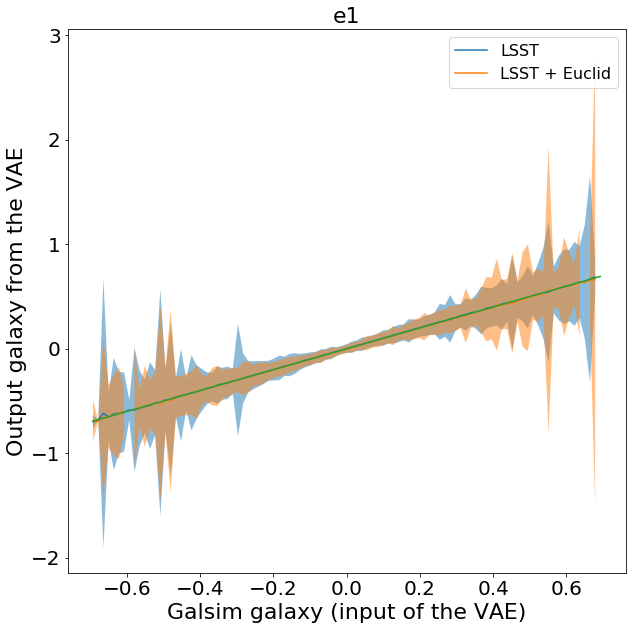

In [202]:
plt.figure(figsize=(10,10))

bins = np.linspace(-0.7, 0.7, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(ellipticities_LSST[:,0,0],ellipticities_LSST[:,1,0],bins)
mean_multi, var_multi = mean_var(ellipticities_LSST_euclid[:,0,0],ellipticities_LSST_euclid[:,1,0],bins)

plt.plot(mid, mean_simple, label = 'LSST')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'LSST + Euclid')
plt.fill_between(mid, mean_simple - 100*var_simple**0.5, mean_simple + 100*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 100*var_multi**0.5, mean_multi + 100*var_multi**0.5, alpha=0.5)
plt.ylabel('Output galaxy from the VAE', fontsize = 22)
plt.xlabel('Galsim galaxy (input of the VAE)', fontsize = 22)
plt.title('e1', fontsize = 22)
plt.legend(fontsize = 16)

#plt.spines['bottom'].set_color('w')
#plt.spines['right'].set_color('w')
#plt.spines['left'].set_color('w')
#plt.spines['top'].set_color('w')
#plt.xaxis.label.set_color('w')
#plt.tick_params(axis='x', colors='w')
#plt.tick_params(axis='y', colors='w')

plt.plot(mid, mid)

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


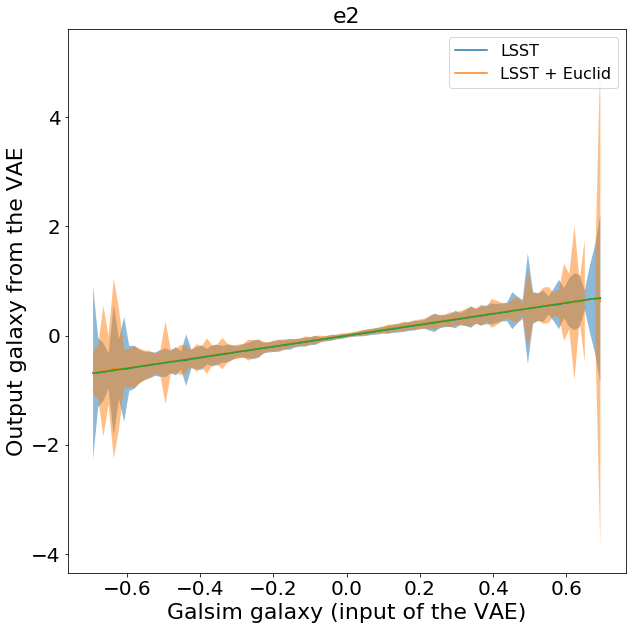

In [205]:
plt.figure(figsize=(10,10))

bins = np.linspace(-0.7, 0.7, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(ellipticities_LSST[:,0,1],ellipticities_LSST[:,1,1],bins)
mean_multi, var_multi = mean_var(ellipticities_LSST_euclid[:,0,1],ellipticities_LSST_euclid[:,1,1],bins)

plt.plot(mid, mean_simple, label = 'LSST')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'LSST + Euclid')
plt.fill_between(mid, mean_simple - 100*var_simple**0.5, mean_simple + 100*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 100*var_multi**0.5, mean_multi + 100*var_multi**0.5, alpha=0.5)
plt.ylabel('Output galaxy from the VAE', fontsize = 22)
plt.xlabel('Galsim galaxy (input of the VAE)', fontsize = 22)
plt.title('e2', fontsize = 22)
plt.legend(fontsize = 16)
plt.plot(mid, mid)

## Flux comparison

In [18]:
# initialize some arrays to zero
lum_in_simple = np.empty([N,],dtype='float32')
lum_in_multi= np.empty([N,], dtype='float32')
lum_out_simple= np.empty([N,], dtype='float32')
lum_out_multi= np.empty([N,], dtype='float32')


delta_lum_simple= np.empty([N,], dtype='float32')
delta_lum_multi= np.empty([N,], dtype='float32')

fig=plt.figure(figsize=(6*3,30*3))
columns = 4
rows =10
cont = 0

list_galsim_simple = input_vae_no_noise_lsst_r_band
list_galsim_multi = input_vae_no_noise_lsst

list_gal_out_simple = vae_lsst_r_band.predict(input_vae_lsst_r_band, batch_size= 100)
list_gal_out_multi = vae_lsst_2000.predict(input_vae_lsst, batch_size= 100)

# Calculate the luminosity as the total luminosity of the image: sum over all the pixels
for i in range (N):
    # Circular mask to evaluate the luminosity in that circle
    mask = createCircularMask(64,64,None,5)
    masked_img_in_simple = list_galsim_simple[i].copy()
    masked_img_in_simple[~mask] = 0  
    
    masked_img_in_multi = list_galsim_multi[i].reshape(6,64,64)[3].copy()
    masked_img_in_multi[~mask] = 0

    masked_img_out_simple = list_gal_out_simple[i].copy()
    masked_img_out_simple[~mask] = 0

    masked_img_out_multi = list_gal_out_multi[i].reshape(6,64,64)[3].copy()
    masked_img_out_multi[~mask] = 0

    # Calculate the luminosity by substracting the noise
    lum_in_simple[i] = np.sum(masked_img_in_simple)
    lum_out_simple[i] = np.sum(masked_img_out_simple)
    lum_in_multi[i] = np.sum(masked_img_in_multi)
    lum_out_multi[i] = np.sum(masked_img_out_multi)


    # Calculate the differences between input and output of deblender
    delta_lum_simple[i] = (lum_in_simple[i] - lum_out_simple[i])#/lum_in_1[i]
    delta_lum_multi[i] = (lum_in_multi[i] - lum_out_multi[i])#/lum_in_2[i]

<Figure size 1296x6480 with 0 Axes>

In [19]:
print(lum_in_simple, lum_out_simple)

[31.714296  12.519497  25.535929  ...  6.3283587 18.49002   28.707935 ] [42.99124  31.833992 23.249805 ... 14.619323 20.268929 43.34626 ]


/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


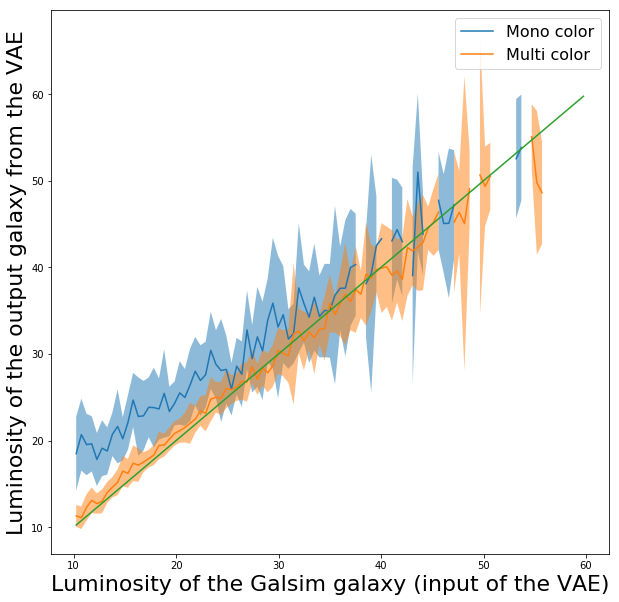

In [31]:
plt.figure(figsize=(10,10))

bins = np.linspace(10., 60, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(lum_in_simple,lum_out_simple,bins)
mean_multi, var_multi = mean_var(lum_in_multi,lum_out_multi,bins)

plt.plot(mid, mean_simple, label = 'Mono color')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'Multi color')
plt.fill_between(mid, mean_simple - 10*var_simple**0.5, mean_simple + 10*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.ylabel('Luminosity of the output galaxy from the VAE', fontsize = 22)
plt.xlabel('Luminosity of the Galsim galaxy (input of the VAE)', fontsize = 22)
plt.legend(fontsize = 16)
plt.plot(mid, mid)

In [32]:
# initialize some arrays to zero
lum_in_simple = np.empty([N,],dtype='float32')
lum_in_multi= np.empty([N,], dtype='float32')
lum_out_simple= np.empty([N,], dtype='float32')
lum_out_multi= np.empty([N,], dtype='float32')


delta_lum_simple= np.empty([N,], dtype='float32')
delta_lum_multi= np.empty([N,], dtype='float32')

fig=plt.figure(figsize=(6*3,30*3))
columns = 4
rows =10
cont = 0

list_galsim_simple = input_vae_no_noise_lsst_r_band
list_galsim_multi = input_vae_no_noise_lsst

list_gal_out_simple = vae_lsst_r_band.predict(input_vae_lsst_r_band, batch_size= 100)
list_gal_out_multi = vae_lsst_2000.predict(input_vae_lsst, batch_size= 100)

# Calculate the luminosity as the total luminosity of the image: sum over all the pixels
for i in range (N):
    # Circular mask to evaluate the luminosity in that circle
    mask = createCircularMask(64,64,None,10)
    masked_img_in_simple = list_galsim_simple[i].copy()
    masked_img_in_simple[~mask] = 0  
    
    masked_img_in_multi = list_galsim_multi[i].reshape(6,64,64)[3].copy()
    masked_img_in_multi[~mask] = 0

    masked_img_out_simple = list_gal_out_simple[i].copy()
    masked_img_out_simple[~mask] = 0

    masked_img_out_multi = list_gal_out_multi[i].reshape(6,64,64)[3].copy()
    masked_img_out_multi[~mask] = 0

    # Calculate the luminosity by substracting the noise
    lum_in_simple[i] = np.sum(masked_img_in_simple)
    lum_out_simple[i] = np.sum(masked_img_out_simple)
    lum_in_multi[i] = np.sum(masked_img_in_multi)
    lum_out_multi[i] = np.sum(masked_img_out_multi)


    # Calculate the differences between input and output of deblender
    delta_lum_simple[i] = (lum_in_simple[i] - lum_out_simple[i])#/lum_in_1[i]
    delta_lum_multi[i] = (lum_in_multi[i] - lum_out_multi[i])#/lum_in_2[i]

<Figure size 1296x6480 with 0 Axes>

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


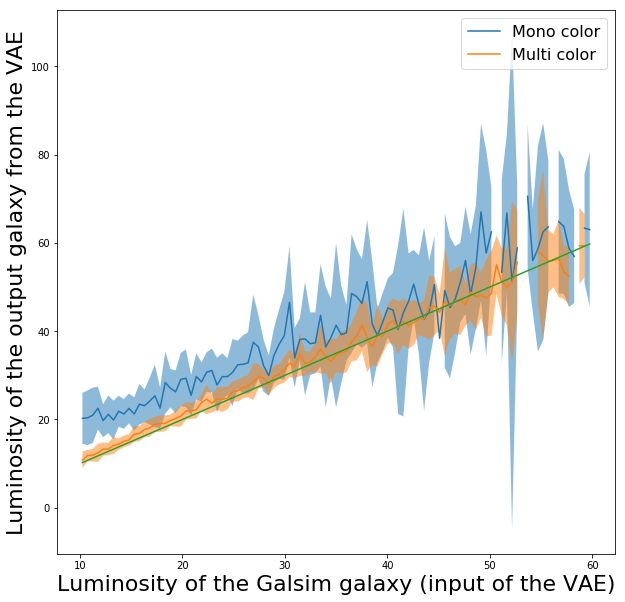

In [33]:
plt.figure(figsize=(10,10))

bins = np.linspace(10., 60, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(lum_in_simple,lum_out_simple,bins)
mean_multi, var_multi = mean_var(lum_in_multi,lum_out_multi,bins)

plt.plot(mid, mean_simple, label = 'Mono color')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'Multi color')
plt.fill_between(mid, mean_simple - 10*var_simple**0.5, mean_simple + 10*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.ylabel('Luminosity of the output galaxy from the VAE', fontsize = 22)
plt.xlabel('Luminosity of the Galsim galaxy (input of the VAE)', fontsize = 22)
plt.legend(fontsize = 16)
plt.plot(mid, mid)

In [36]:
# initialize some arrays to zero
lum_in_simple = np.empty([N,],dtype='float32')
lum_in_multi= np.empty([N,], dtype='float32')
lum_out_simple= np.empty([N,], dtype='float32')
lum_out_multi= np.empty([N,], dtype='float32')


delta_lum_simple= np.empty([N,], dtype='float32')
delta_lum_multi= np.empty([N,], dtype='float32')

fig=plt.figure(figsize=(6*3,30*3))
columns = 4
rows =10
cont = 0

list_galsim_simple = input_vae_no_noise_lsst_r_band
list_galsim_multi = input_vae_no_noise_lsst

list_gal_out_simple = vae_lsst_r_band.predict(input_vae_lsst_r_band, batch_size= 100)
list_gal_out_multi = vae_lsst_2000.predict(input_vae_lsst, batch_size= 100)

# Calculate the luminosity as the total luminosity of the image: sum over all the pixels
for i in range (N):
    # Circular mask to evaluate the luminosity in that circle
    mask = createCircularMask(64,64,None,32)
    masked_img_in_simple = list_galsim_simple[i].copy()
    masked_img_in_simple[~mask] = 0  
    
    masked_img_in_multi = list_galsim_multi[i].reshape(6,64,64)[3].copy()
    masked_img_in_multi[~mask] = 0

    masked_img_out_simple = list_gal_out_simple[i].copy()
    masked_img_out_simple[~mask] = 0

    masked_img_out_multi = list_gal_out_multi[i].reshape(6,64,64)[3].copy()
    masked_img_out_multi[~mask] = 0

    # Calculate the luminosity by substracting the noise
    lum_in_simple[i] = np.sum(masked_img_in_simple)
    lum_out_simple[i] = np.sum(masked_img_out_simple)
    lum_in_multi[i] = np.sum(masked_img_in_multi)
    lum_out_multi[i] = np.sum(masked_img_out_multi)


    # Calculate the differences between input and output of deblender
    delta_lum_simple[i] = (lum_in_simple[i] - lum_out_simple[i])#/lum_in_1[i]
    delta_lum_multi[i] = (lum_in_multi[i] - lum_out_multi[i])#/lum_in_2[i]

<Figure size 1296x6480 with 0 Axes>

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


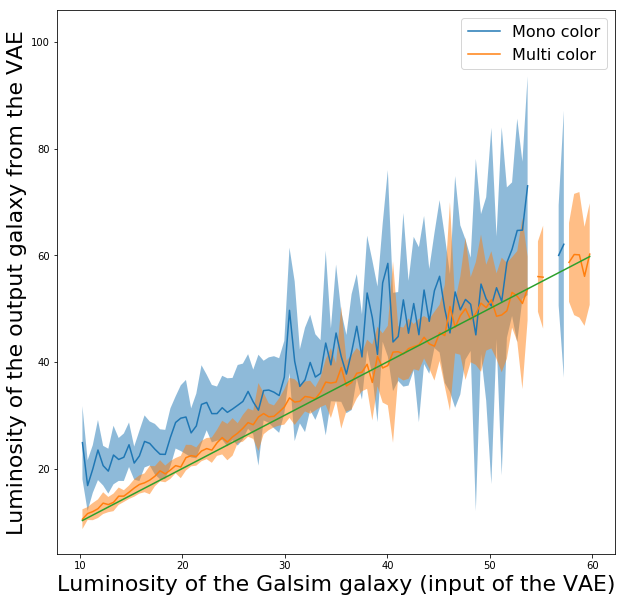

In [37]:
plt.figure(figsize=(10,10))

bins = np.linspace(10., 60, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(lum_in_simple,lum_out_simple,bins)
mean_multi, var_multi = mean_var(lum_in_multi,lum_out_multi,bins)

plt.plot(mid, mean_simple, label = 'Mono color')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'Multi color')
plt.fill_between(mid, mean_simple - 10*var_simple**0.5, mean_simple + 10*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.ylabel('Luminosity of the output galaxy from the VAE', fontsize = 22)
plt.xlabel('Luminosity of the Galsim galaxy (input of the VAE)', fontsize = 22)
plt.legend(fontsize = 16)
plt.plot(mid, mid)

# Test N iterations of the same galaxy

In [13]:
input_R = batch_gen.__getitem__(56)

In [15]:
input_R[0].shape

(100, 64, 64)

In [19]:
input_lsst = batch_gen_lsst.__getitem__(56)

In [24]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

measures=[]
e_mes=[]
for i in range (1000):
    output_vae = vae_lsst_conv.predict(input_lsst[0], batch_size = batch_size)
    gal_image = galsim.Image(output_vae[0].reshape((6,64,64))[2])
    gal_image.scale = pix_scale
    measures= galsim.hsm.EstimateShear(gal_image, psf_image)
    e_mes.append([measures.corrected_e1, measures.corrected_e2])

In [ ]:
e1 = np.concatenate(e_mes, axis = 0)
e2 = np.concatenate(e_mes, axis = 1)

In [ ]:
e1.shape, e2.shape

In [ ]:
_ = plt.hist(e_mes)